In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid

import nibabel

In [2]:
%matplotlib inline
def show(img):
    
    npimg = img.numpy()
    #print(npimg.shape)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [3]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [4]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72, 
        85, 251, 252, 253, 254, 255]

In [5]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)
        
#         image = (image - image.min())/(image.max() - image.min())
#         aseg_img = (aseg_img - aseg_img.min()) / (aseg_img.max() - aseg_img.min())
#         print(image.shape)
#         print(image.max())
        
        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((44,256,256))
        for i,a in enumerate(available_segments):
            target_label[i,:,:] = (target==a).astype(int)
#             xyz = (target==a).astype(int)
#             target_label[i,:,:] = (xyz - xyz.min())/(xyz.max() - xyz.min()+1e-7)
        target_label = torch.from_numpy(target_label)
        im = (im - torch.min(im))/(torch.max(im) - torch.min(im)+1e-7)
        #print("img",im.size())
        #print(target_label.size())
        sample = {'x':im,'y':target_label} 
#         print("orig",im)
#         print("target",target_label)
        return sample

In [6]:
# # torch.from_numpy()
# train_file_names = unpickling("/scratch/ark576/train_file_names")
# train_label_names = unpickling("/scratch/ark576/train_label_names")
# rand1 = np.arange(len(train_file_names))
# np.random.shuffle(rand1)
# rand1 = rand1[:1000]

# val_file_names = unpickling("/scratch/ark576/val_file_names")
# val_label_names = unpickling("/scratch/ark576/val_label_names")
# rand2 = np.arange(len(val_file_names))
# np.random.shuffle(rand2)
# rand2 = rand2[:250]

# test_file_names = unpickling("/scratch/ark576/test_file_names")
# test_label_names = unpickling("/scratch/ark576/test_label_names")
# rand3 = np.arange(len(test_file_names))
# np.random.shuffle(rand3)
# rand3 = rand3[:3]




In [7]:
file_names = pd.read_csv("all_complete_path.csv")

In [8]:
file_names.head()

,left_to_right_raw,left_to_right_segmented,top_to_bottom_raw,top_to_bottom_segmented,back_to_front_raw,back_to_front_segmented
0,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
1,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
2,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
3,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
4,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...


In [9]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [10]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [11]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:1000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:500]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [12]:
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2]),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3])
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=12,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [13]:
np.random.randn(10,10).max()

1.8986510679394348

In [16]:
inputs = next(iter(dataloader['train']))

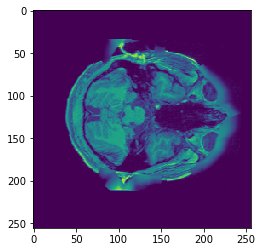

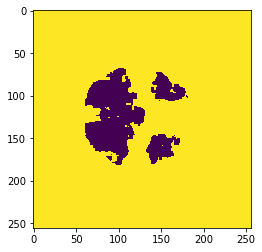

In [17]:
j = 3
plt.imshow(inputs['x'][1,0,:,:].numpy())
plt.show()
plt.imshow(inputs['y'][1,0,:,:].numpy())
plt.show()

In [18]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [19]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [20]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(1,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,44, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [21]:
voxel_count = pd.read_csv('/cbi/hcp/hcp_seg/brain_segmentation/segment_counts.csv')

In [22]:
wts_num = np.mean(np.array(voxel_count.iloc[:,available_segments]),axis = 0)

In [23]:
wts_torch = Variable(torch.from_numpy(wts_num)).cuda()

In [24]:
def dice_loss_2(true1,scores1,mean, epsilon = 1e-4,p = 1):
    N, C, sh1, sh2 = true1.size()
    
    true = []
    scores = []
    for c in range(N):
        if not torch.sum(true1[c,1:,:,:])==0:
            true.append(true1[c,:,:,:])
            scores.append(scores1[c,:,:,:])
    try:
        true = torch.stack(true)
        scores = torch.stack(scores)
    except:
        return -1
    N, C, sh1, sh2 = true.size()
    
    
    preds = F.softmax(scores)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
    mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [25]:
def dice_score(true1,scores1, epsilon = 1e-7):
    N ,C, sh1, sh2 = true1.size()
    true = []
    scores = []
    for c in range(N):
        if not torch.sum(true1[c,1:,:,:])==0:
            true.append(true1[c,:,:,:])
            scores.append(scores1[c,:,:,:])
    try:
        true = torch.stack(true)
        scores = torch.stack(scores)
    except:
        return 0
    
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*44
    for i in range(44):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*44
    for i in range(44):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [26]:
import time
def train_model(model, optimizer,dataloader, data_sizes, batch_size, num_epochs = 100, verbose = False):
    since = time.time()
    best_loss = np.inf
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(44)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*44
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).type(torch.FloatTensor).cuda()
                y = Variable(y).type(torch.FloatTensor).cuda()
                
                output = model(x)
                loss = dice_loss_2(y, output,wts_torch)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * batch_size
                dice_score_batch = dice_score(y,output)

                for j in range(44):
                    run_class_scores[j] = run_class_scores[j] + dice_score_batch[j] * batch_size
            epoch_loss = running_loss/data_sizes[phase]
            loss_hist[phase].append(epoch_loss.item()) 
            for j in range(44):
                score = run_class_scores[j]/data_sizes[phase]
                dice_scores_of_all_class[j][phase].append(score.to(torch.device("cpu")).numpy())
            if verbose or i%1 == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}'.format(i,phase,epoch_loss))
                print('-'*10)
            
        if phase == 'validate' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict() 
        print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist, dice_scores_of_all_class

In [27]:
model = Unet().cuda()
model = nn.DataParallel(model)
criterion = dice_loss_2

optimizer = optim.Adam(model.parameters(),lr = 5e-4)

In [28]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,12,
                                                                num_epochs = 20, verbose = True)

Epoch: 0, Phase: train, epoch loss: 0.9960
----------
Epoch: 0, Phase: validate, epoch loss: 1.0079
----------
0
Epoch: 1, Phase: train, epoch loss: 1.0079
----------
Epoch: 1, Phase: validate, epoch loss: 1.0077
----------
1
Epoch: 2, Phase: train, epoch loss: 1.0076
----------
Epoch: 2, Phase: validate, epoch loss: 1.0076
----------
2
Epoch: 3, Phase: train, epoch loss: 0.9993
----------
Epoch: 3, Phase: validate, epoch loss: 0.9881
----------
3
Epoch: 4, Phase: train, epoch loss: 0.9478
----------
Epoch: 4, Phase: validate, epoch loss: 0.9308
----------
4
Epoch: 5, Phase: train, epoch loss: 0.8342
----------
Epoch: 5, Phase: validate, epoch loss: 0.7726
----------
5
Epoch: 6, Phase: train, epoch loss: 0.7540
----------
Epoch: 6, Phase: validate, epoch loss: 0.7442
----------
6
Epoch: 7, Phase: train, epoch loss: 0.6874
----------
Epoch: 7, Phase: validate, epoch loss: 0.7355
----------
7
Epoch: 8, Phase: train, epoch loss: 0.6634
----------
Epoch: 8, Phase: validate, epoch loss: 0.6

In [37]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [38]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,12,
                                                                num_epochs = 20, verbose = True)

Epoch: 0, Phase: train, epoch loss: 0.5930
----------
Epoch: 0, Phase: validate, epoch loss: 0.5615
----------
0
Epoch: 1, Phase: train, epoch loss: 0.5821
----------
Epoch: 1, Phase: validate, epoch loss: 0.5700
----------
1
Epoch: 2, Phase: train, epoch loss: 0.5777
----------
Epoch: 2, Phase: validate, epoch loss: 0.5745
----------
2
Epoch: 3, Phase: train, epoch loss: 0.5719
----------
Epoch: 3, Phase: validate, epoch loss: 0.5721
----------
3
Epoch: 4, Phase: train, epoch loss: 0.5936
----------
Epoch: 4, Phase: validate, epoch loss: 0.5541
----------
4
Epoch: 5, Phase: train, epoch loss: 0.5884
----------
Epoch: 5, Phase: validate, epoch loss: 0.5560
----------
5
Epoch: 6, Phase: train, epoch loss: 0.5836
----------
Epoch: 6, Phase: validate, epoch loss: 0.5676
----------
6
Epoch: 7, Phase: train, epoch loss: 0.5797
----------
Epoch: 7, Phase: validate, epoch loss: 0.5722
----------
7
Epoch: 8, Phase: train, epoch loss: 0.5790
----------
Epoch: 8, Phase: validate, epoch loss: 0.5

In [39]:
torch.save(model.state_dict(), "model6")

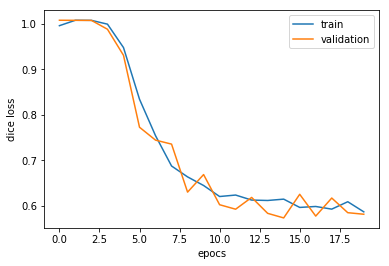

In [30]:
plt.plot(loss_hist["train"],label="train")
plt.plot(loss_hist["validate"],label = "validation")
plt.ylabel("dice loss")
plt.xlabel("epocs")
plt.legend()
plt.show()

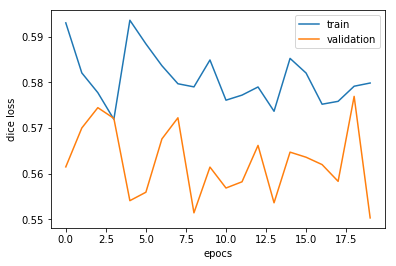

In [40]:
plt.plot(loss_hist["train"],label="train")
plt.plot(loss_hist["validate"],label = "validation")
plt.ylabel("dice loss")
plt.xlabel("epocs")
plt.legend()
plt.show()

In [49]:
optimizer = optim.Adam(model.parameters(),lr = 5e-6)

In [50]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,12,
                                                                num_epochs = 10, verbose = True)

Epoch: 0, Phase: train, epoch loss: 0.5836
----------
Epoch: 0, Phase: validate, epoch loss: 0.5580
----------
0
Epoch: 1, Phase: train, epoch loss: 0.5722
----------
Epoch: 1, Phase: validate, epoch loss: 0.5696
----------
1
Epoch: 2, Phase: train, epoch loss: 0.5732
----------
Epoch: 2, Phase: validate, epoch loss: 0.5557
----------
2
Epoch: 3, Phase: train, epoch loss: 0.5755
----------
Epoch: 3, Phase: validate, epoch loss: 0.5585
----------
3
Epoch: 4, Phase: train, epoch loss: 0.5684
----------
Epoch: 4, Phase: validate, epoch loss: 0.5582
----------
4
Epoch: 5, Phase: train, epoch loss: 0.5866
----------
Epoch: 5, Phase: validate, epoch loss: 0.5625
----------
5
Epoch: 6, Phase: train, epoch loss: 0.5769
----------
Epoch: 6, Phase: validate, epoch loss: 0.5503
----------
6
Epoch: 7, Phase: train, epoch loss: 0.5647
----------
Epoch: 7, Phase: validate, epoch loss: 0.5524
----------
7
Epoch: 8, Phase: train, epoch loss: 0.5700
----------
Epoch: 8, Phase: validate, epoch loss: 0.5

In [83]:
pickling(dice_hist,"model1_dice_hist")

In [141]:
data = next(iter(dataloader["validate"]))

In [142]:
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)

In [143]:
def visualize(image, class_viz, title):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    masked = (p_maxim==class_viz).data.type(torch.cuda.FloatTensor)
    plt.title(title)
    plt.imshow(masked[:,:].cpu().numpy())

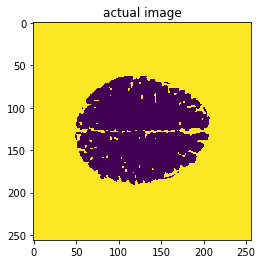

In [145]:
visualize(data['y'][5,:,:,:],0,"actual image") 

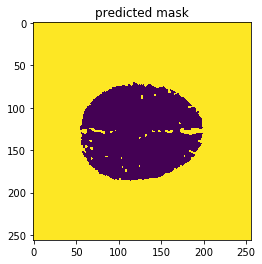

In [146]:
visualize(output[5,:,:,:],0,"predicted mask")

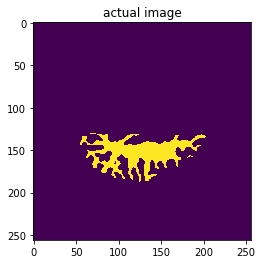

In [147]:
visualize(data['y'][5,:,:,:],1,"actual image") 

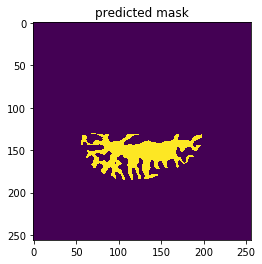

In [148]:
visualize(output[5,:,:,:],1,"predicted mask")

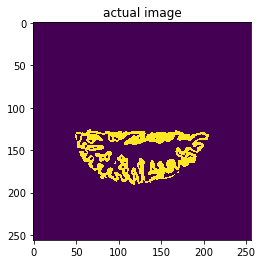

In [151]:
visualize(data['y'][5,:,:,:],2,"actual image") 

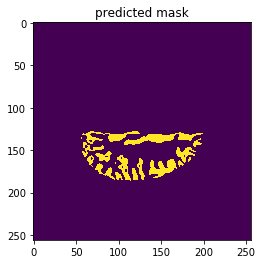

In [153]:
visualize(output[5,:,:,:],2,"predicted mask")

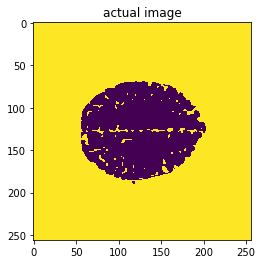

In [158]:
visualize(data['y'][9,:,:,:],0,"actual image") 

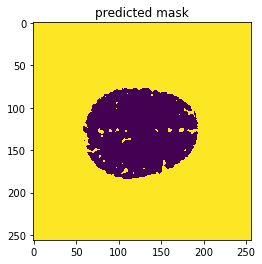

In [157]:
visualize(output[9,:,:,:],0,"predicted mask")

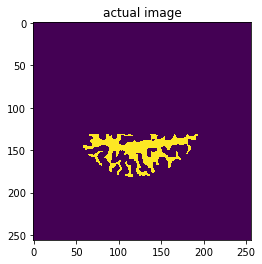

In [159]:
visualize(data['y'][9,:,:,:],1,"actual image") 

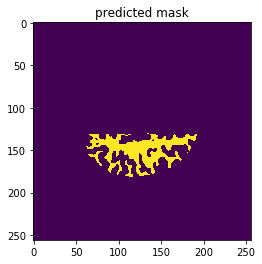

In [160]:
visualize(output[9,:,:,:],1,"predicted mask")

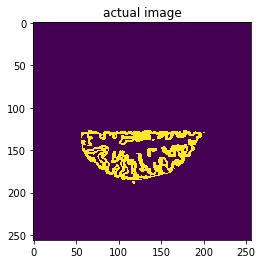

In [161]:
visualize(data['y'][9,:,:,:],2,"actual image") 

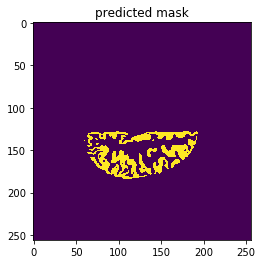

In [162]:
visualize(output[9,:,:,:],2,"predicted mask")

In [34]:
def visualize1(image):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(44):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    #plt.title(title)
    #plt.imshow(masked[:,:].cpu().numpy())
    #print(torch.stack(img).size())
    return torch.stack(img).resize(44,1,256,256).cpu()

In [48]:
# abc = data['y'][5,:,:,:]
# bcd = abc.resize(46,1,256,256)
# show(make_grid(bcd,padding=10,pad_value=1)) 

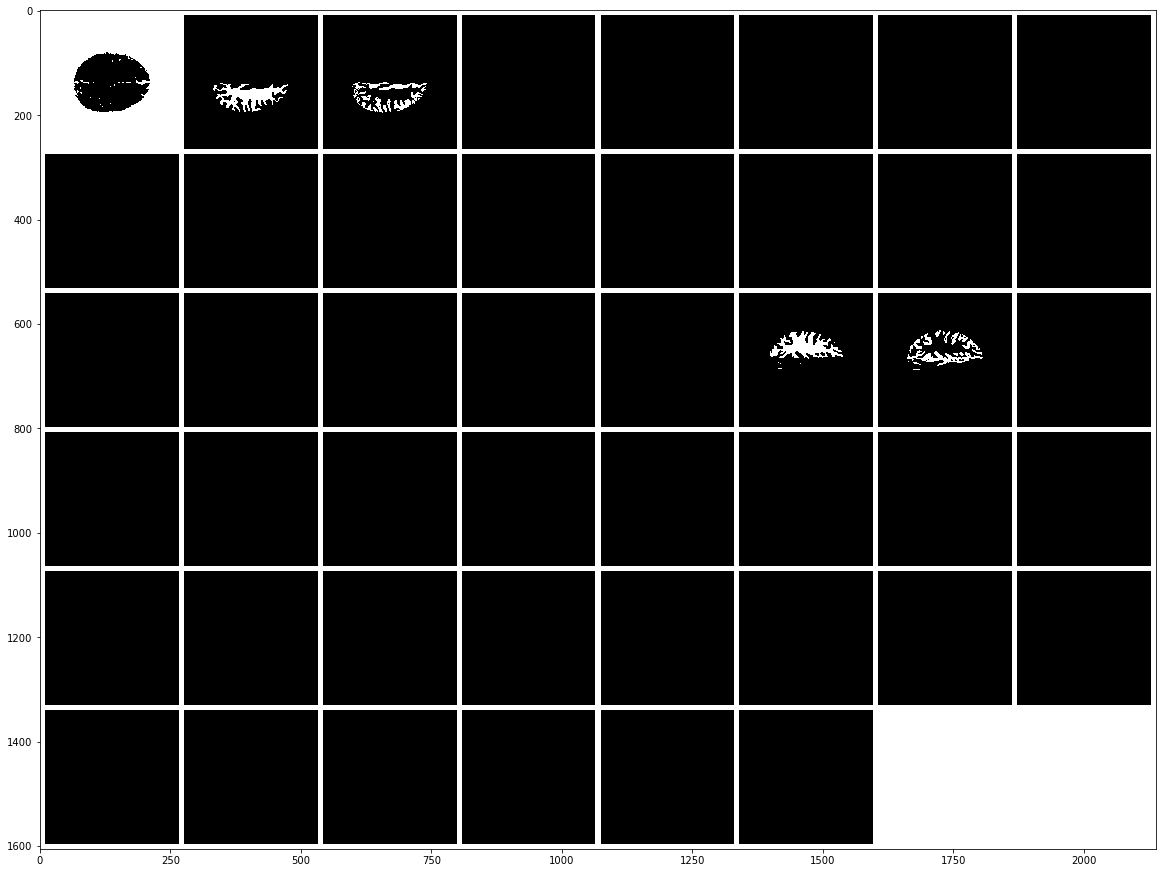

In [227]:
show(make_grid(visualize1(output[5,:,:,:]),padding=10,pad_value=1))

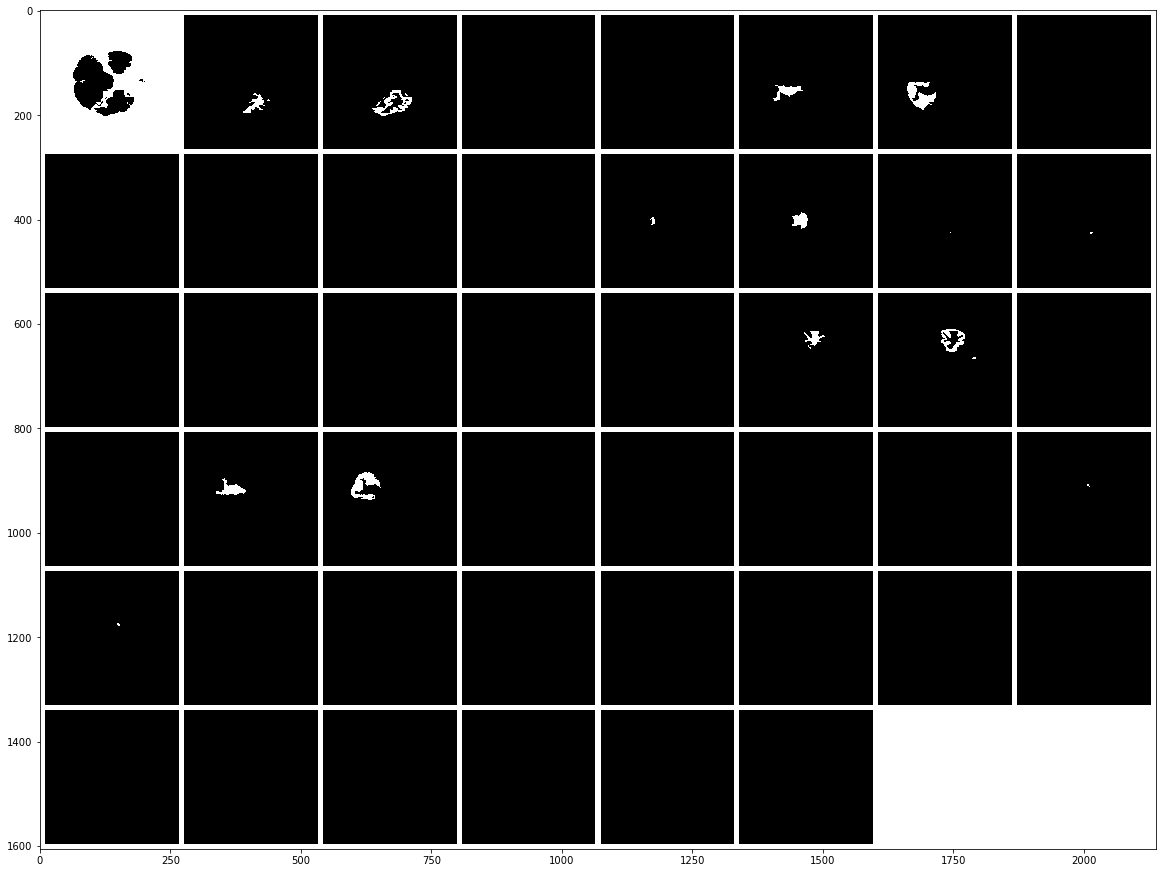

In [232]:
abc = data['y'][10,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1)) 

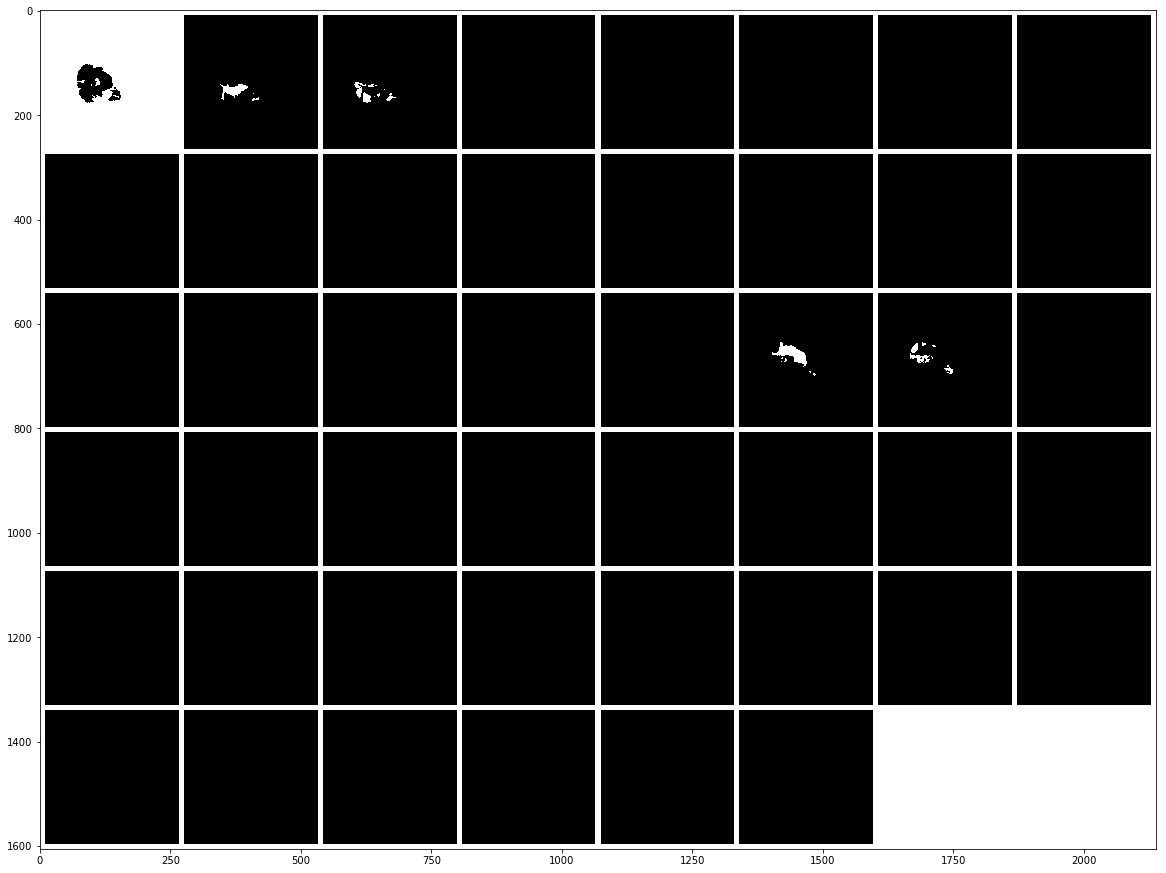

In [233]:
show(make_grid(visualize1(output[10,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


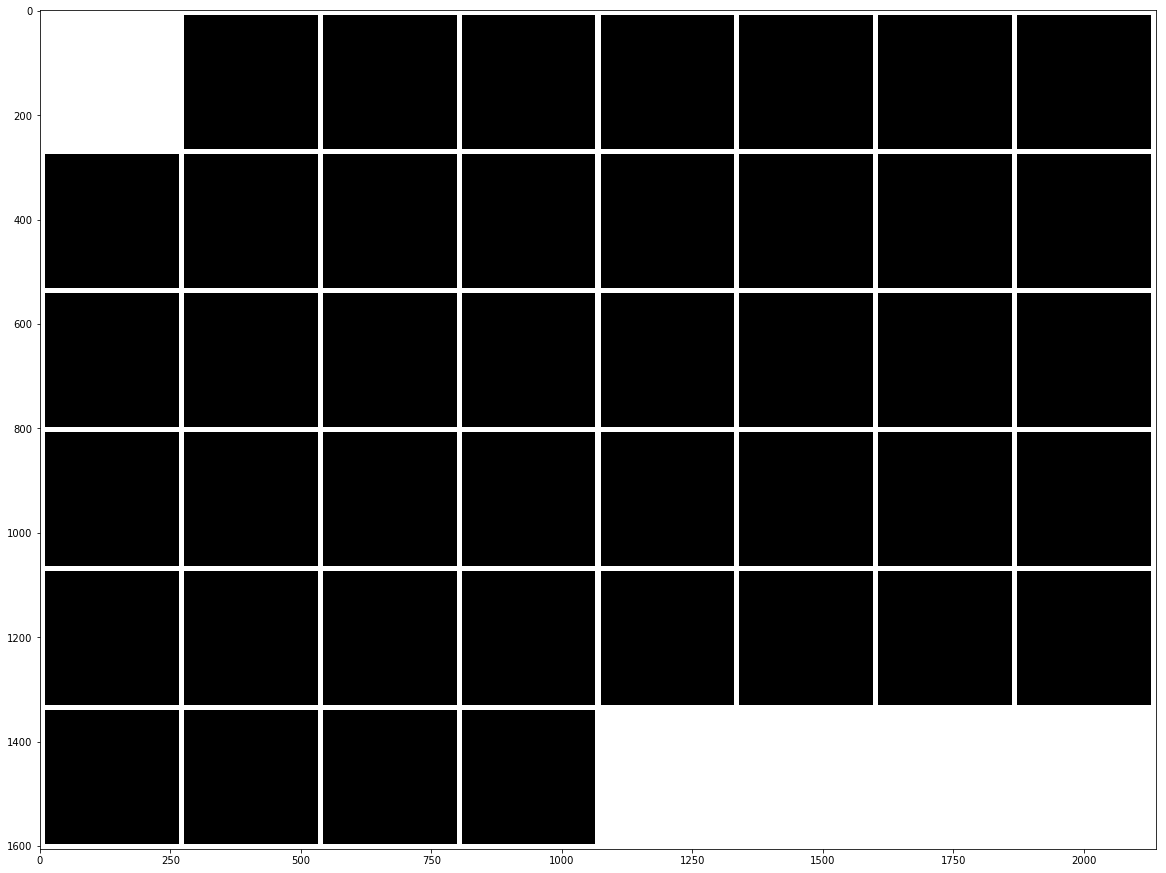

----------------------------------------------------------------------------------------------------
Prediction


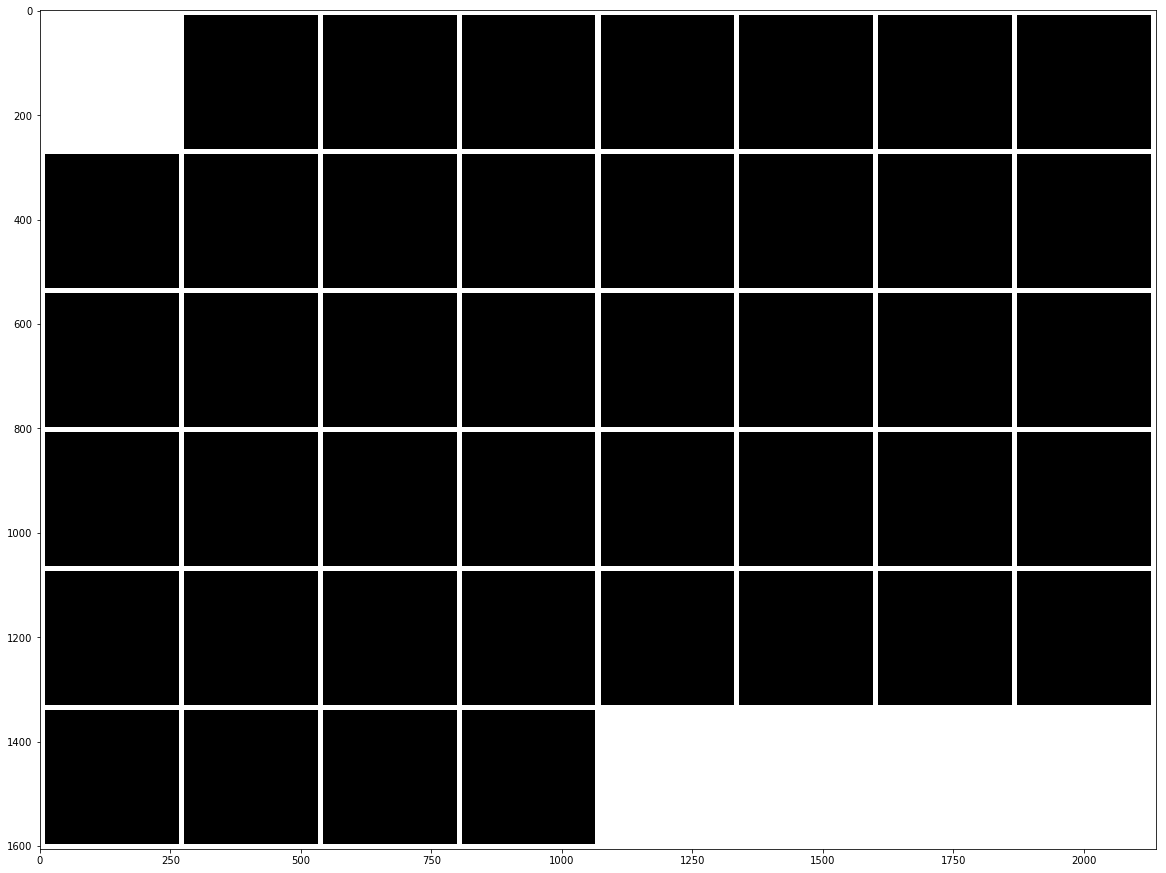

----------------------------------------------------------------------------------------------------
Ground Truth


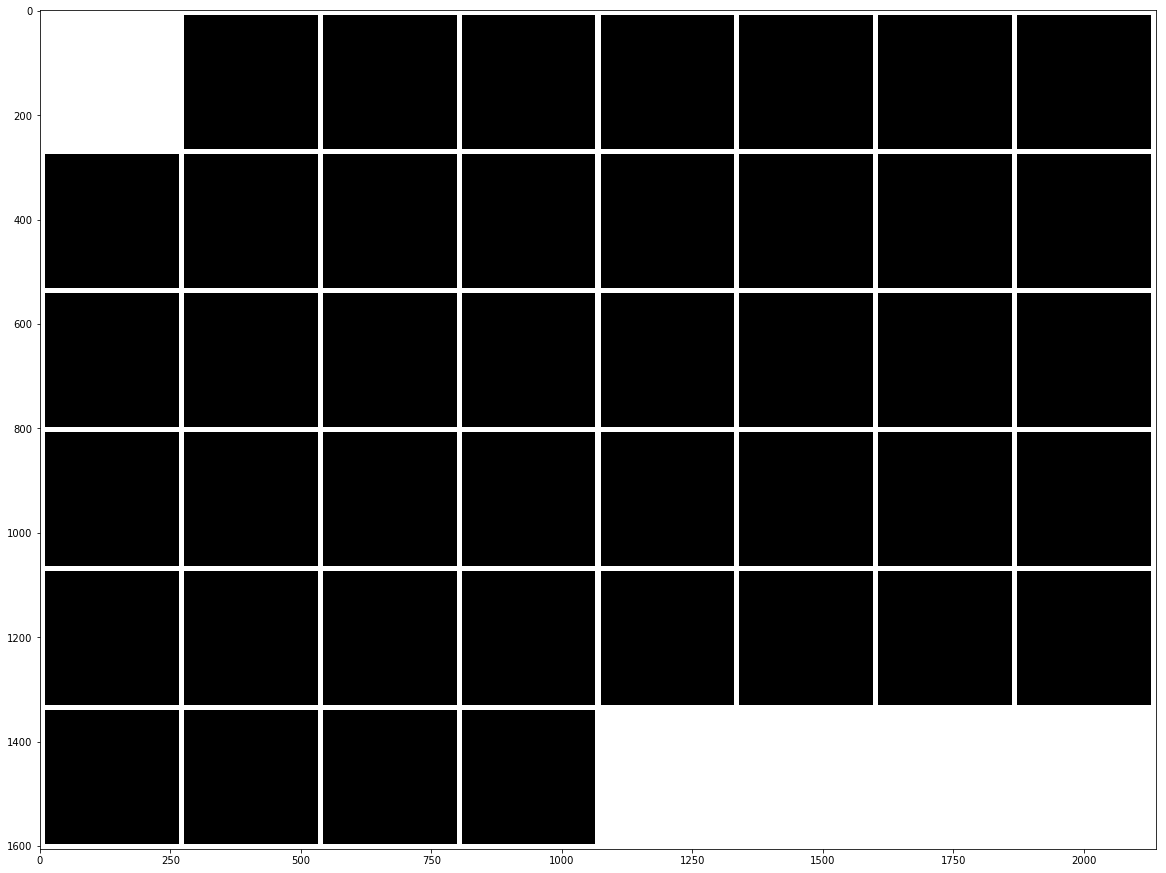

----------------------------------------------------------------------------------------------------
Prediction


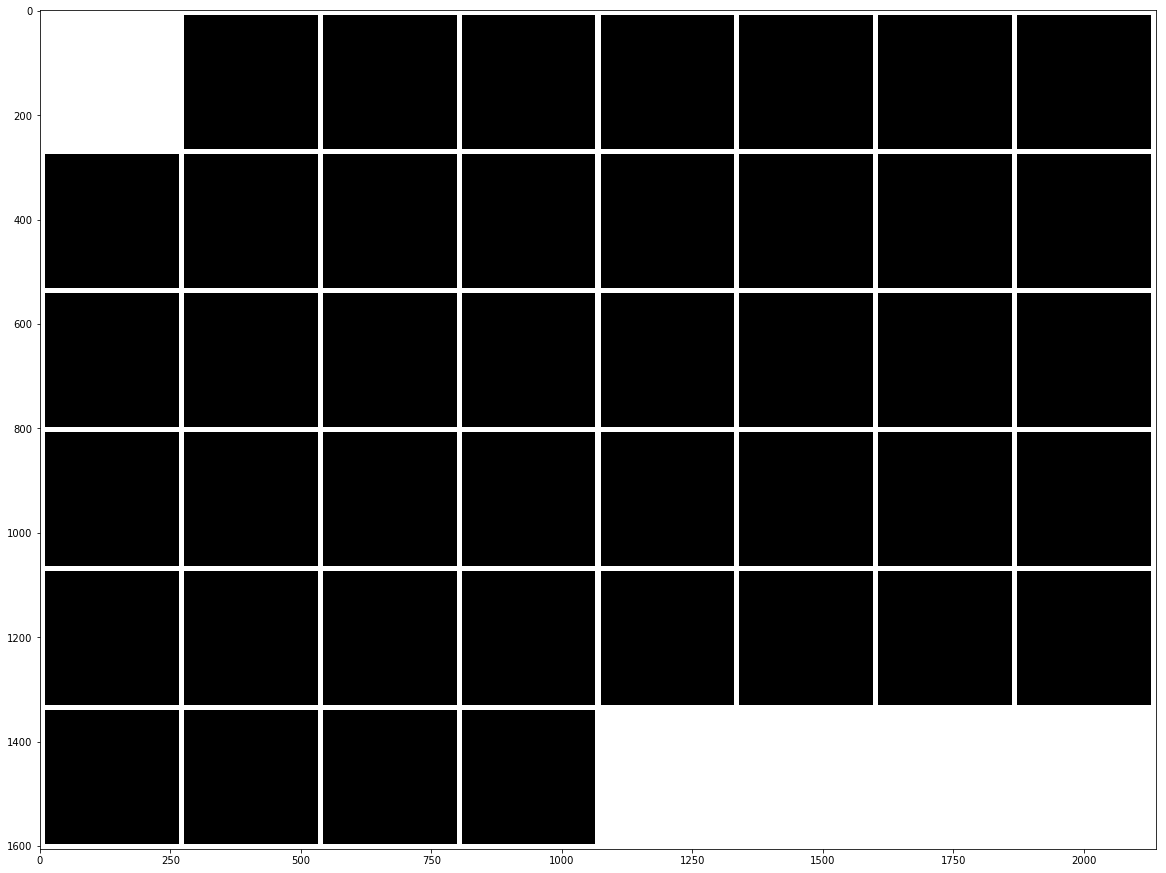

----------------------------------------------------------------------------------------------------
Ground Truth


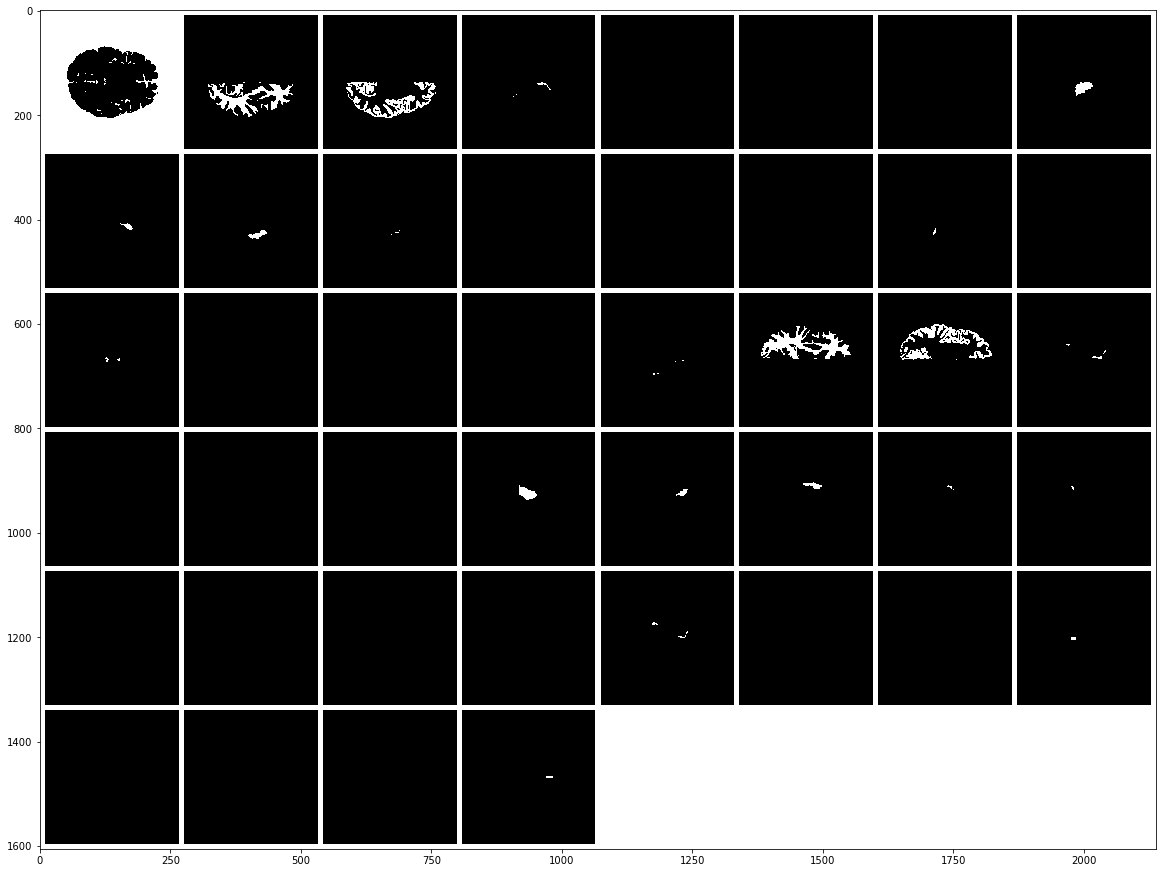

----------------------------------------------------------------------------------------------------
Prediction


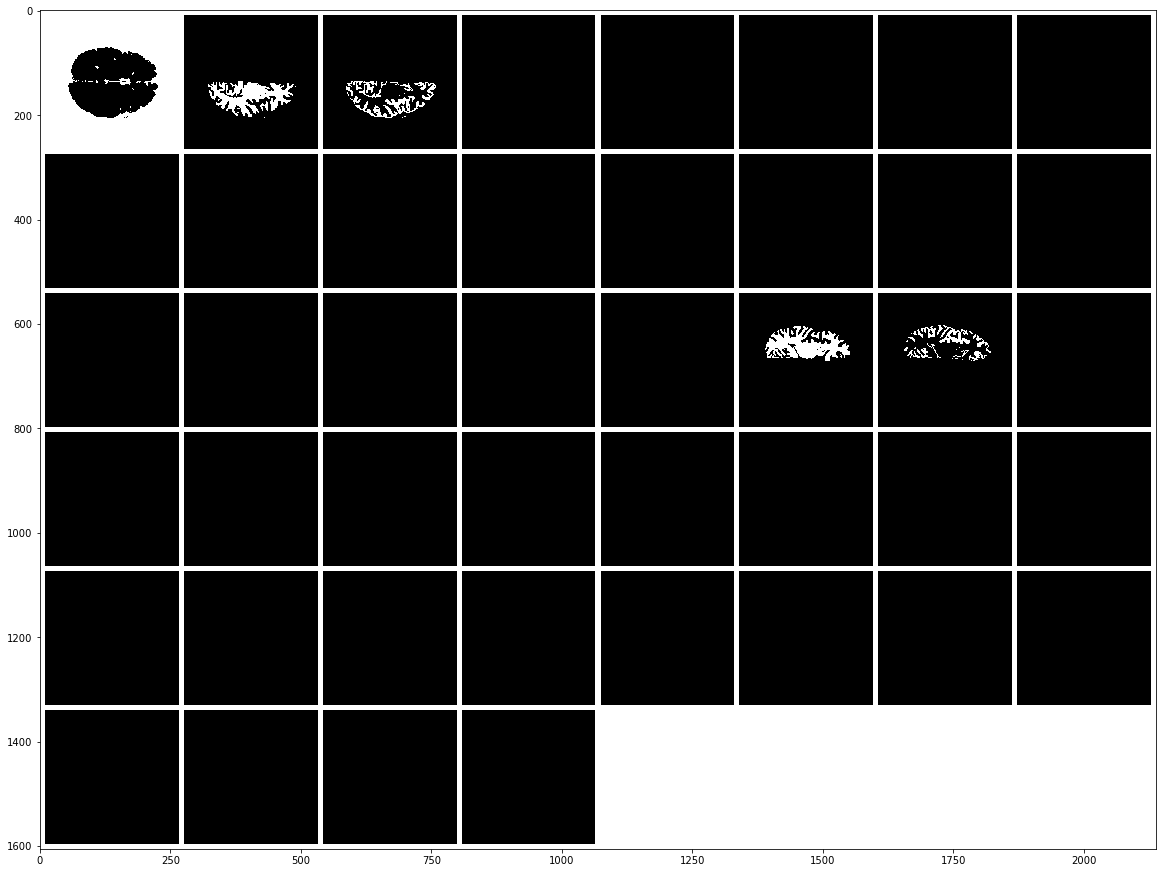

----------------------------------------------------------------------------------------------------
Ground Truth


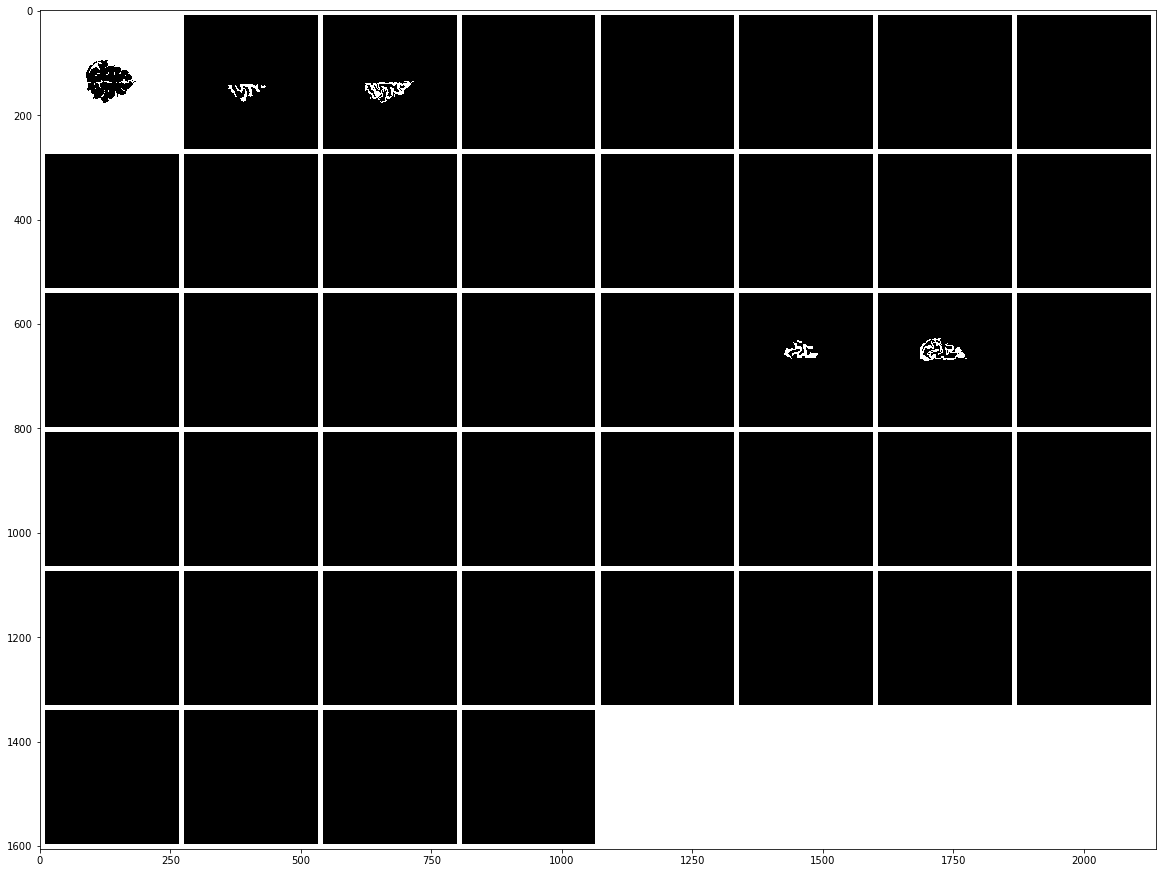

----------------------------------------------------------------------------------------------------
Prediction


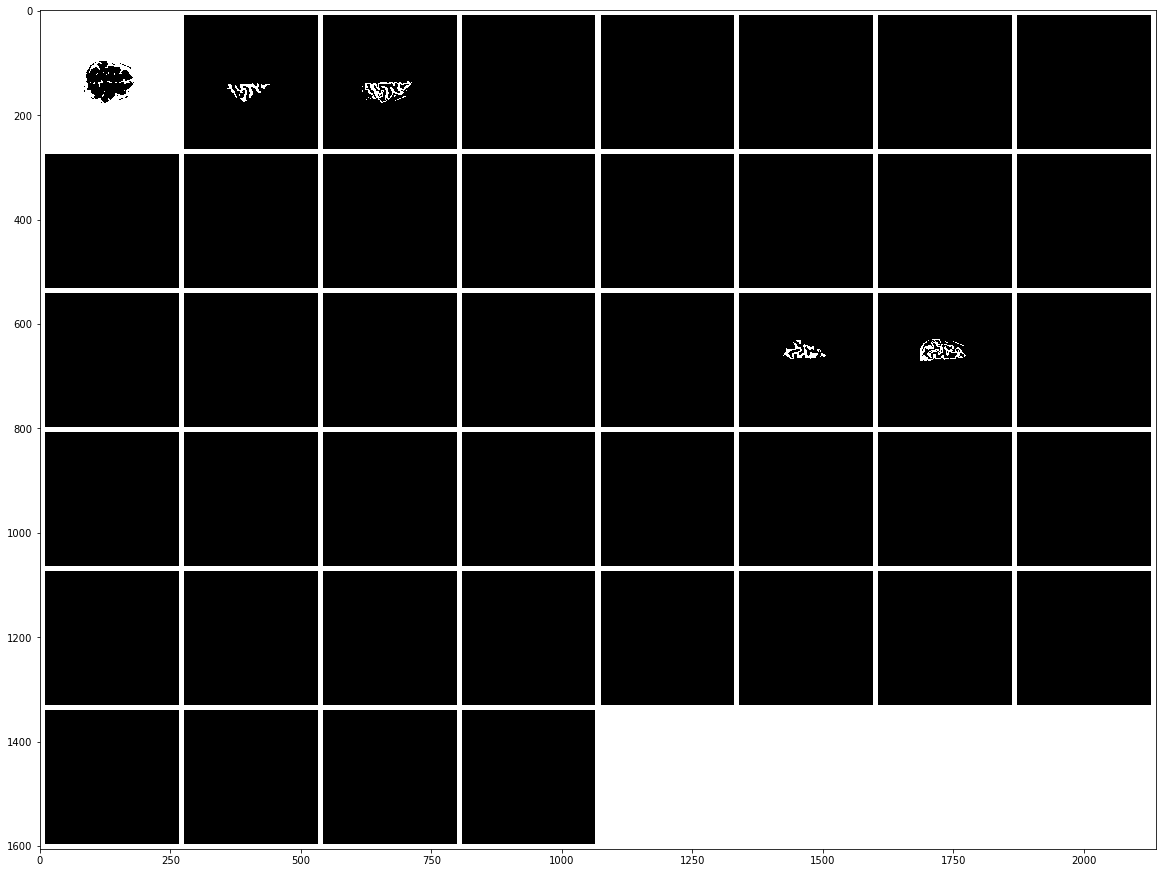

----------------------------------------------------------------------------------------------------
Ground Truth


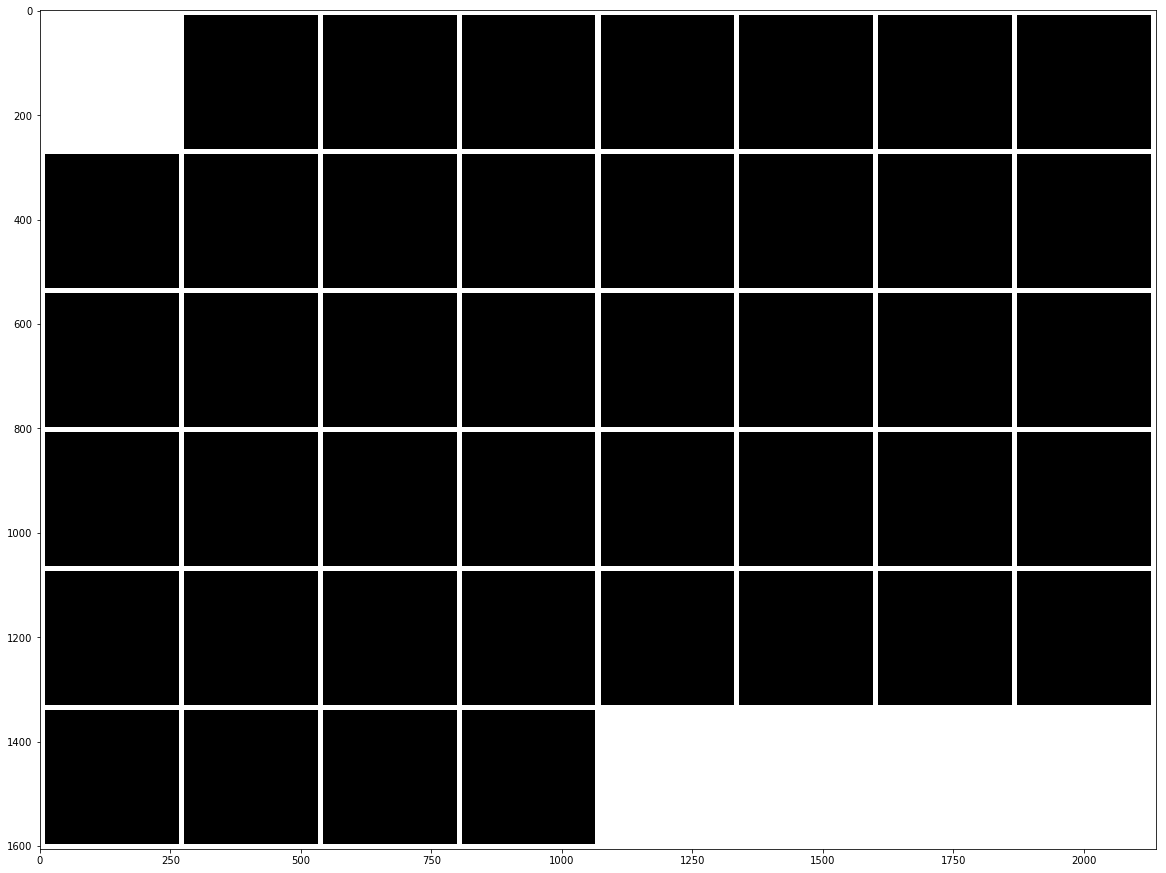

----------------------------------------------------------------------------------------------------
Prediction


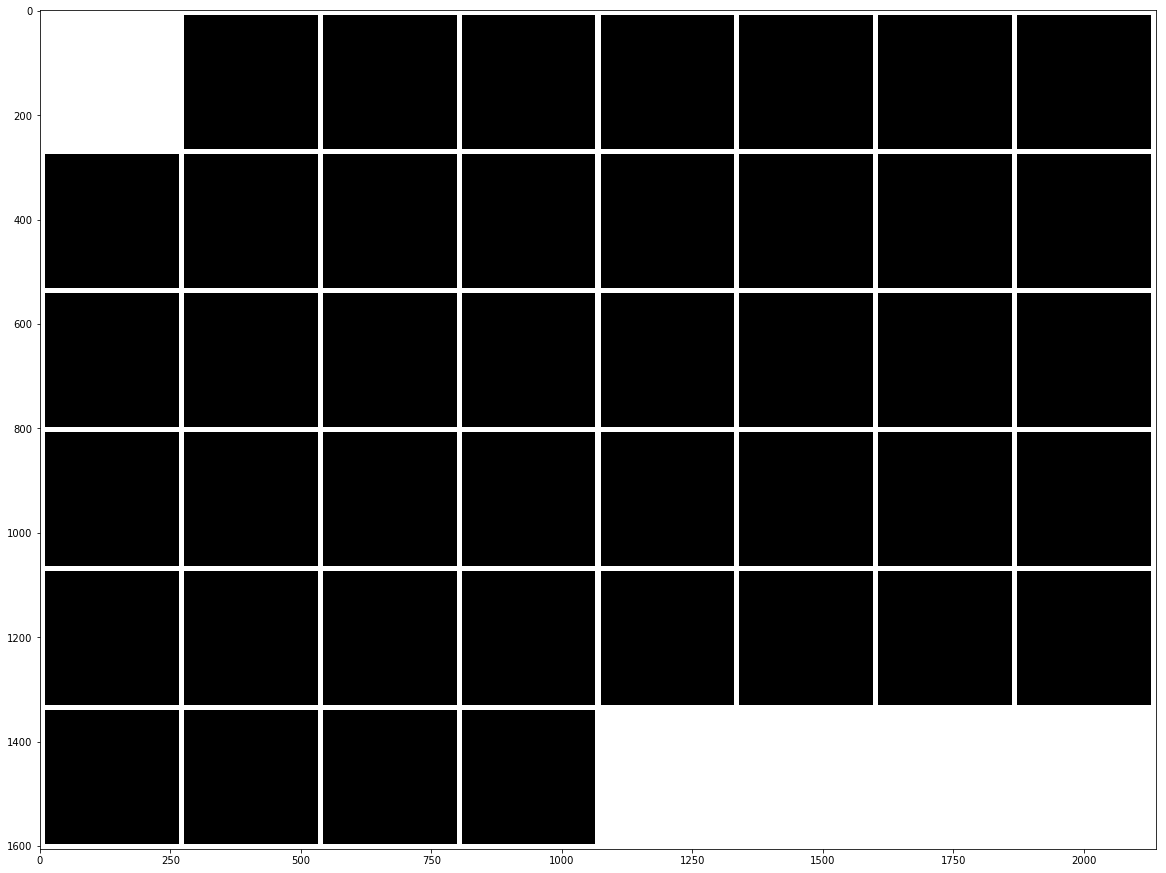

----------------------------------------------------------------------------------------------------
Ground Truth


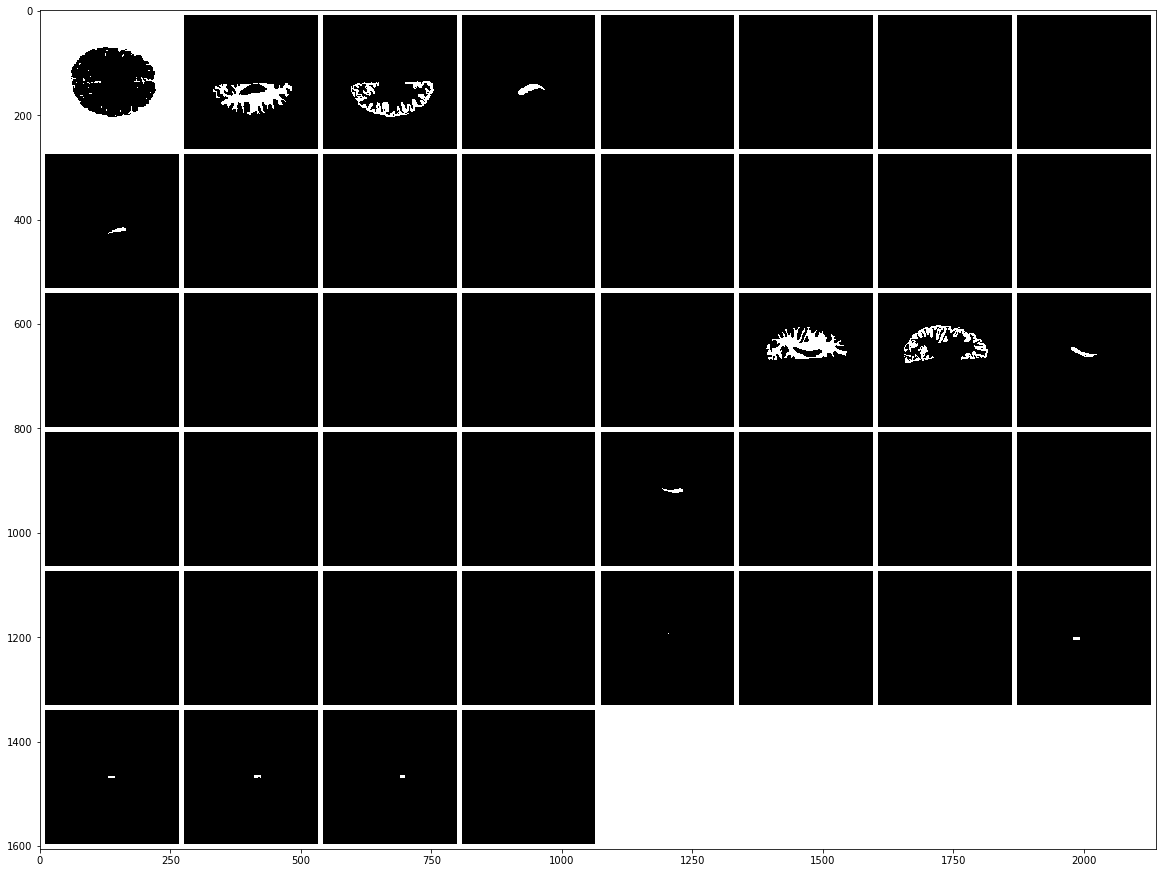

----------------------------------------------------------------------------------------------------
Prediction


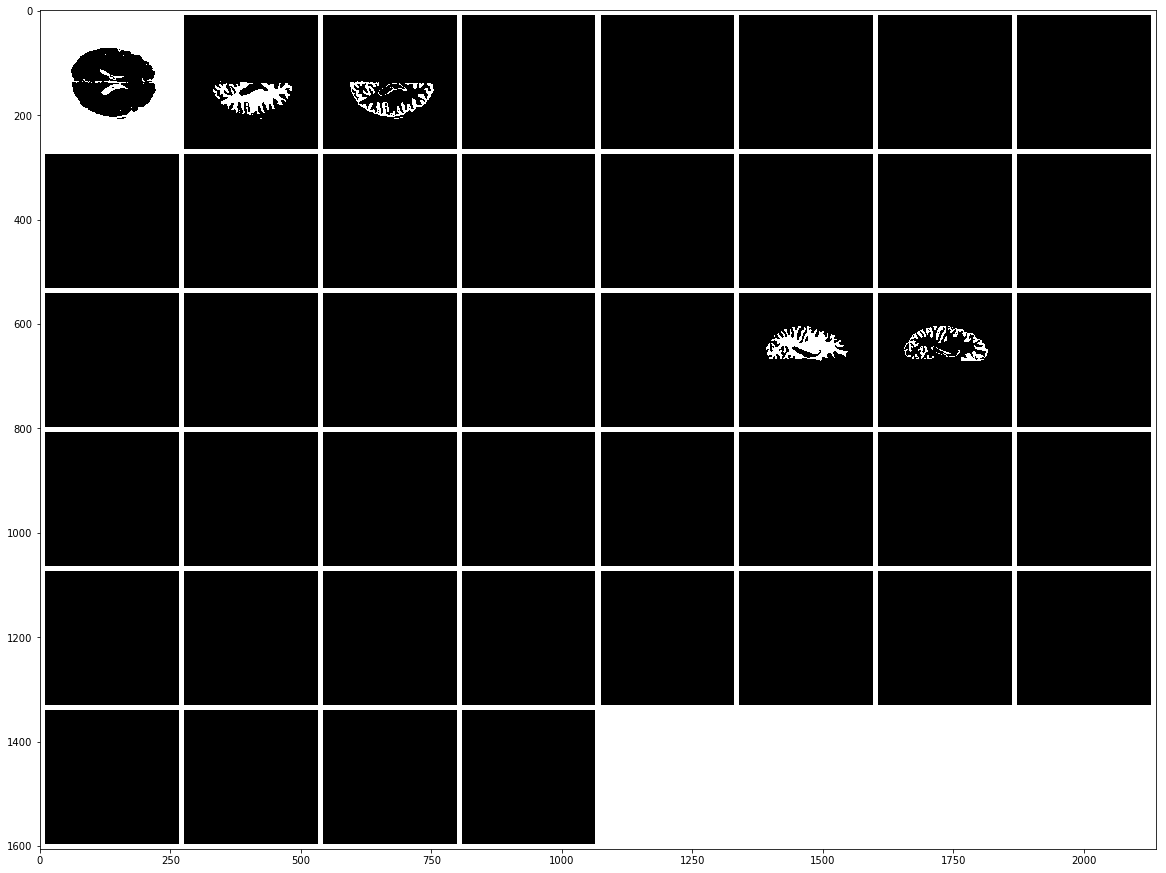

----------------------------------------------------------------------------------------------------
Ground Truth


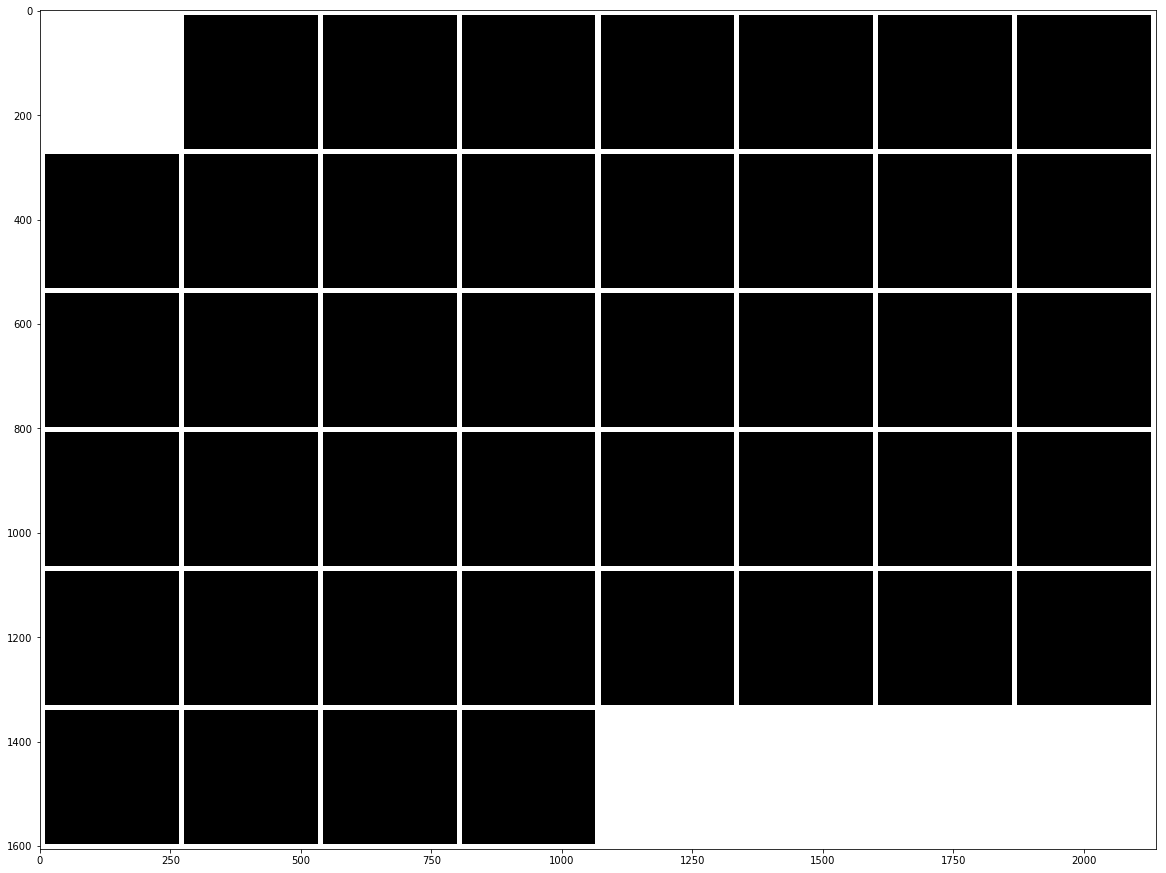

----------------------------------------------------------------------------------------------------
Prediction


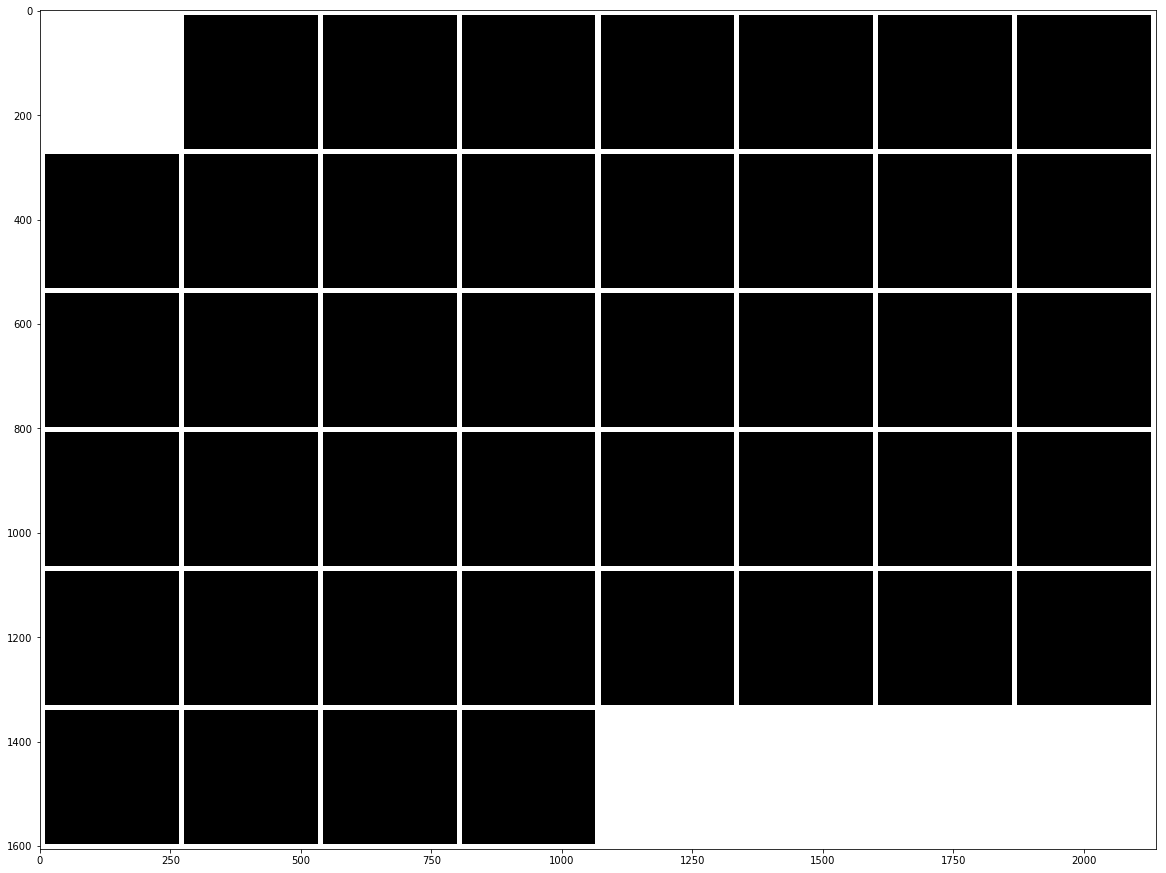

----------------------------------------------------------------------------------------------------
Ground Truth


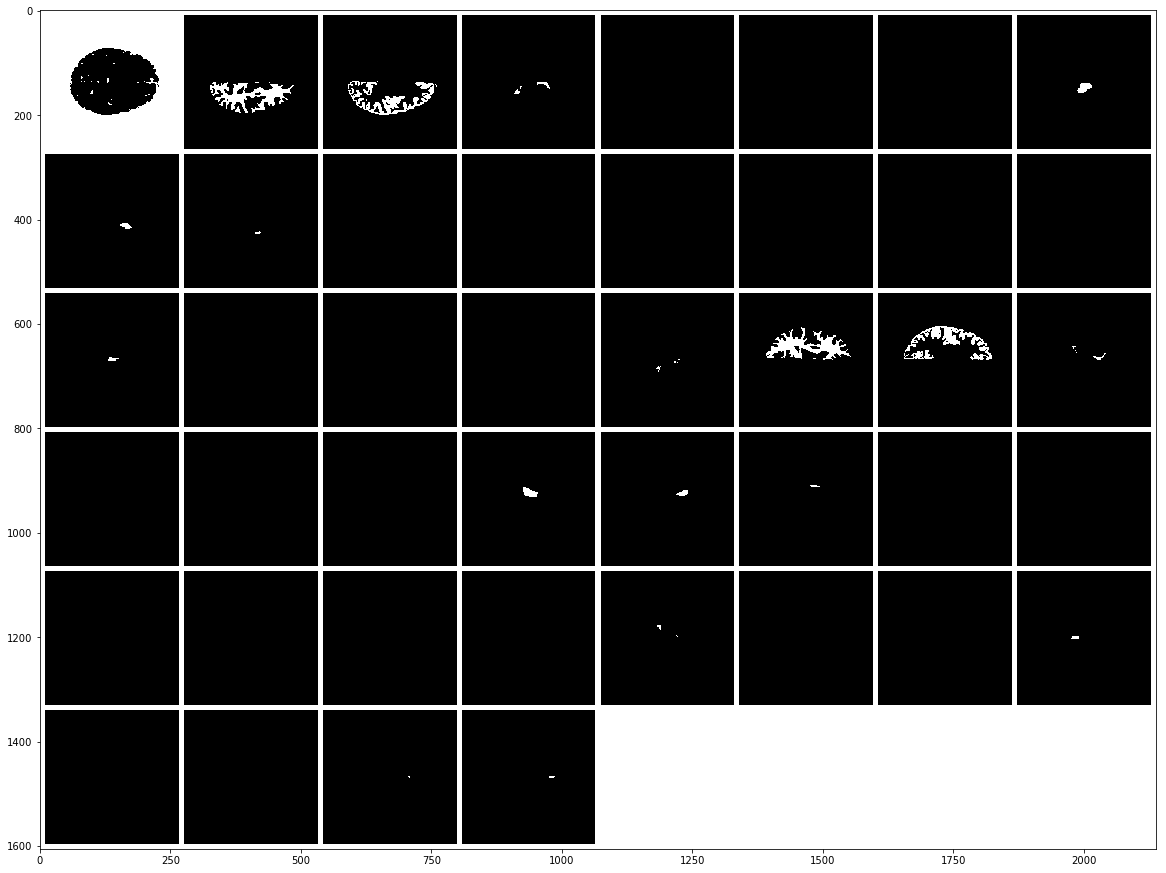

----------------------------------------------------------------------------------------------------
Prediction


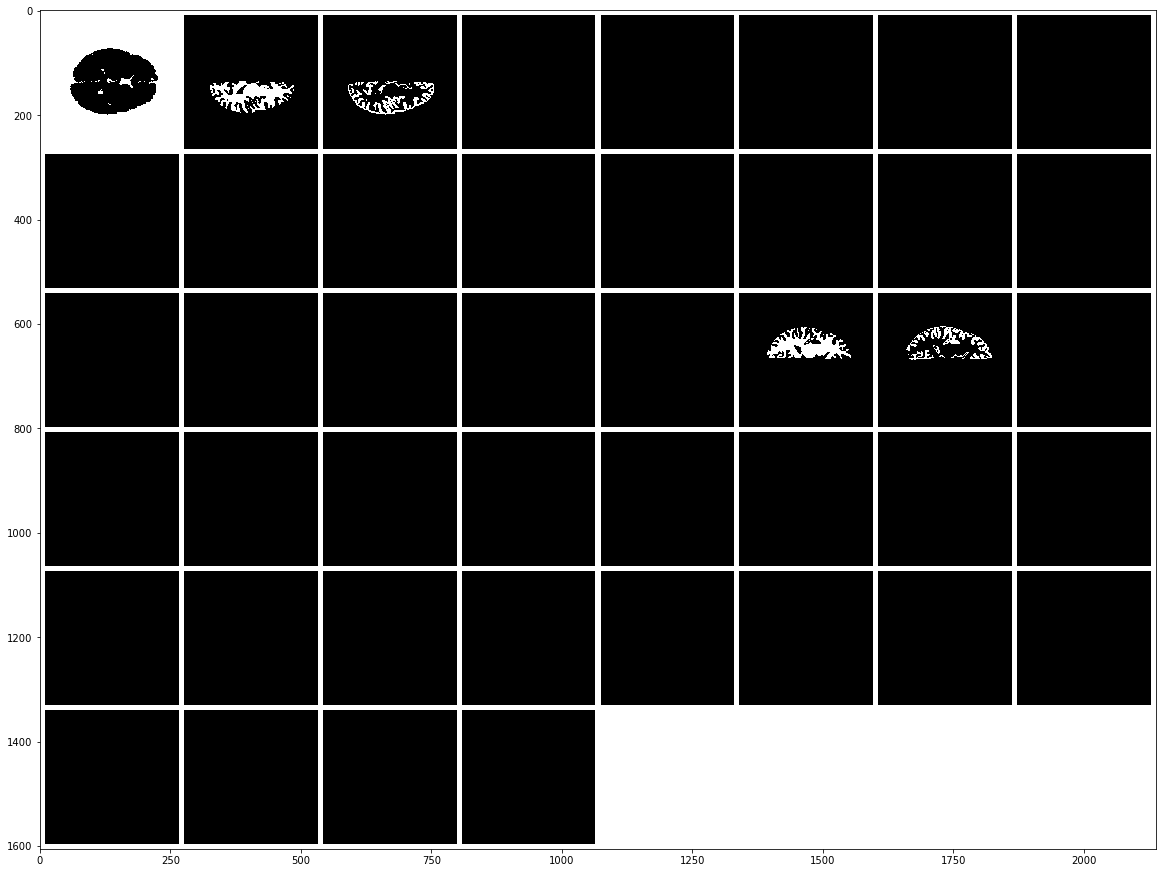

----------------------------------------------------------------------------------------------------
Ground Truth


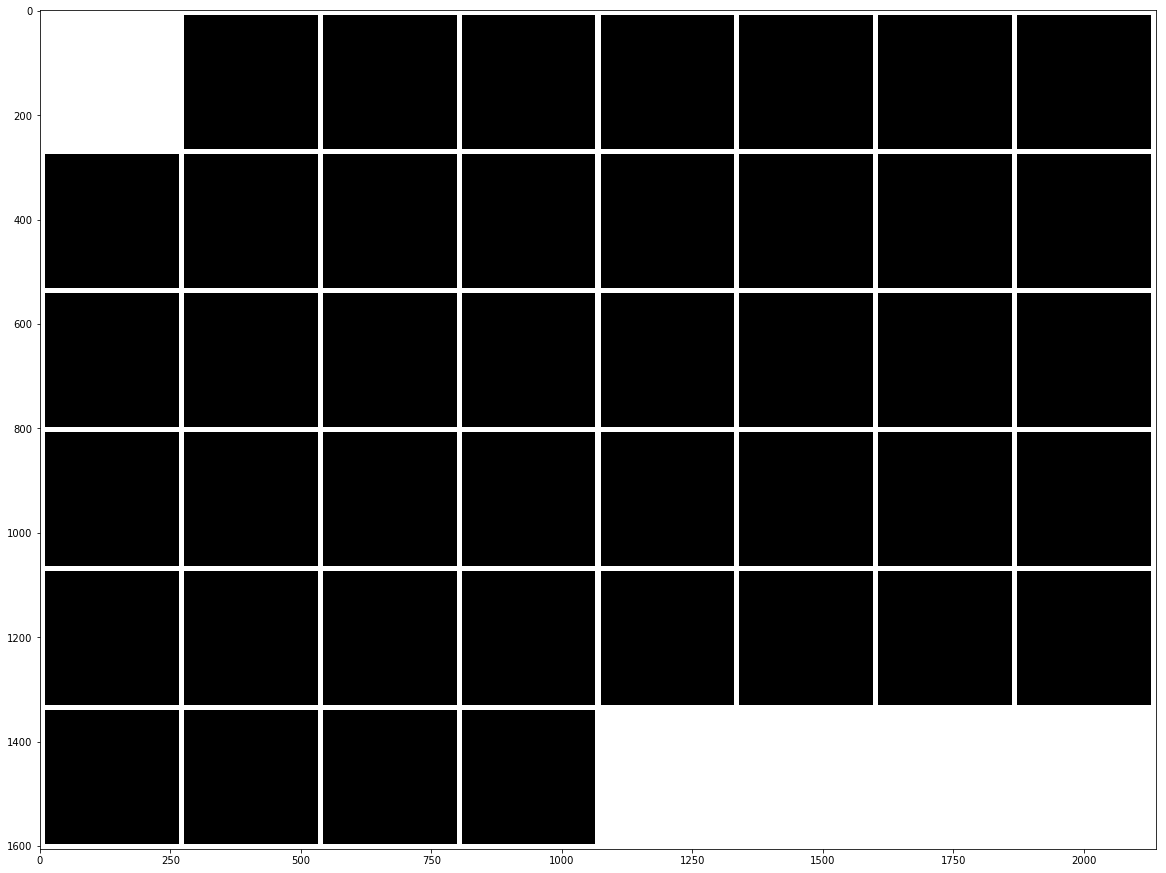

----------------------------------------------------------------------------------------------------
Prediction


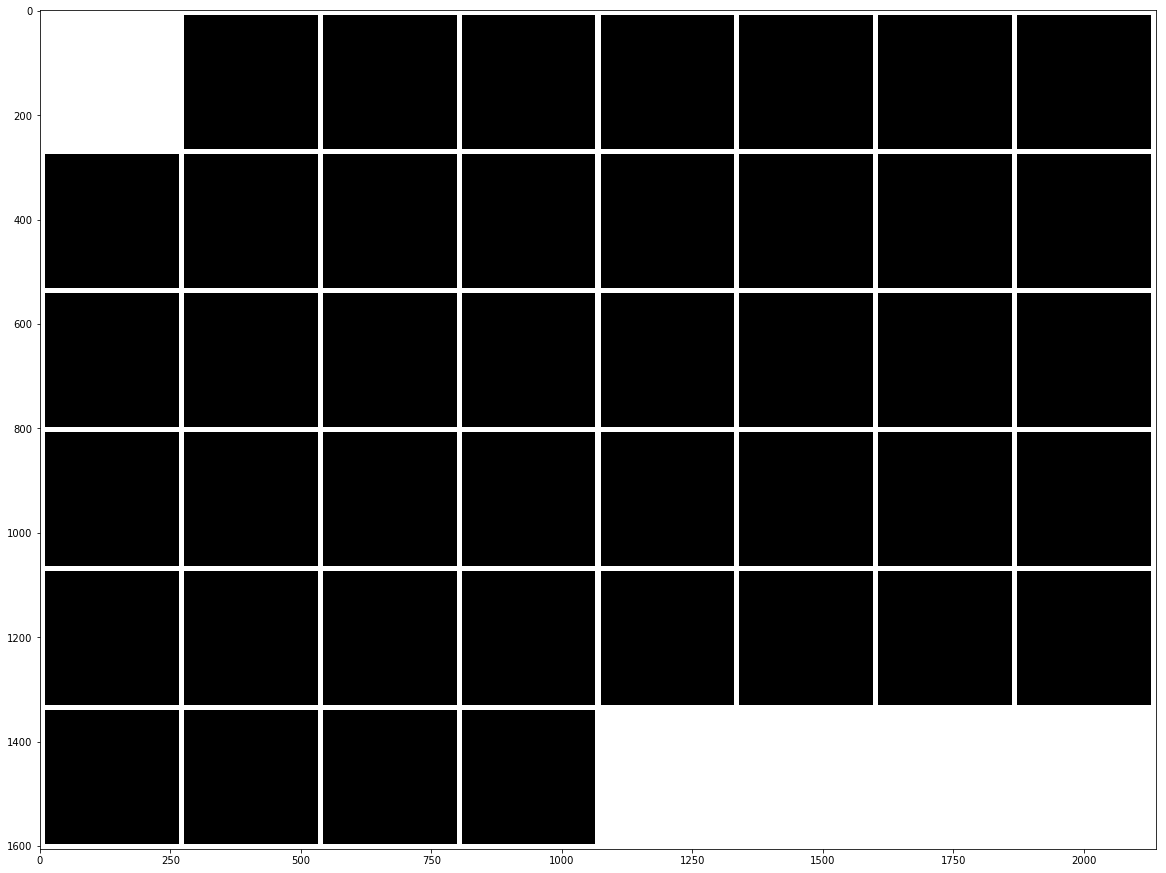

----------------------------------------------------------------------------------------------------
Ground Truth


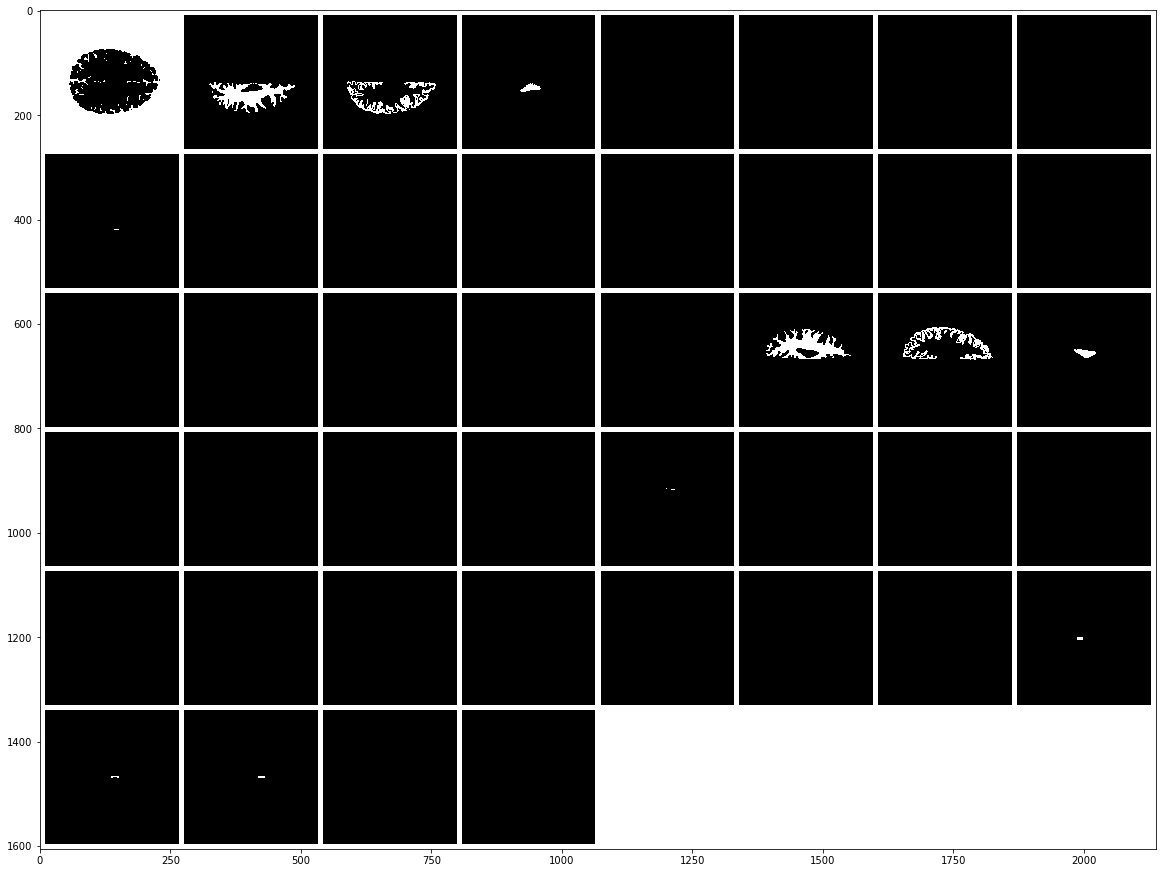

----------------------------------------------------------------------------------------------------
Prediction


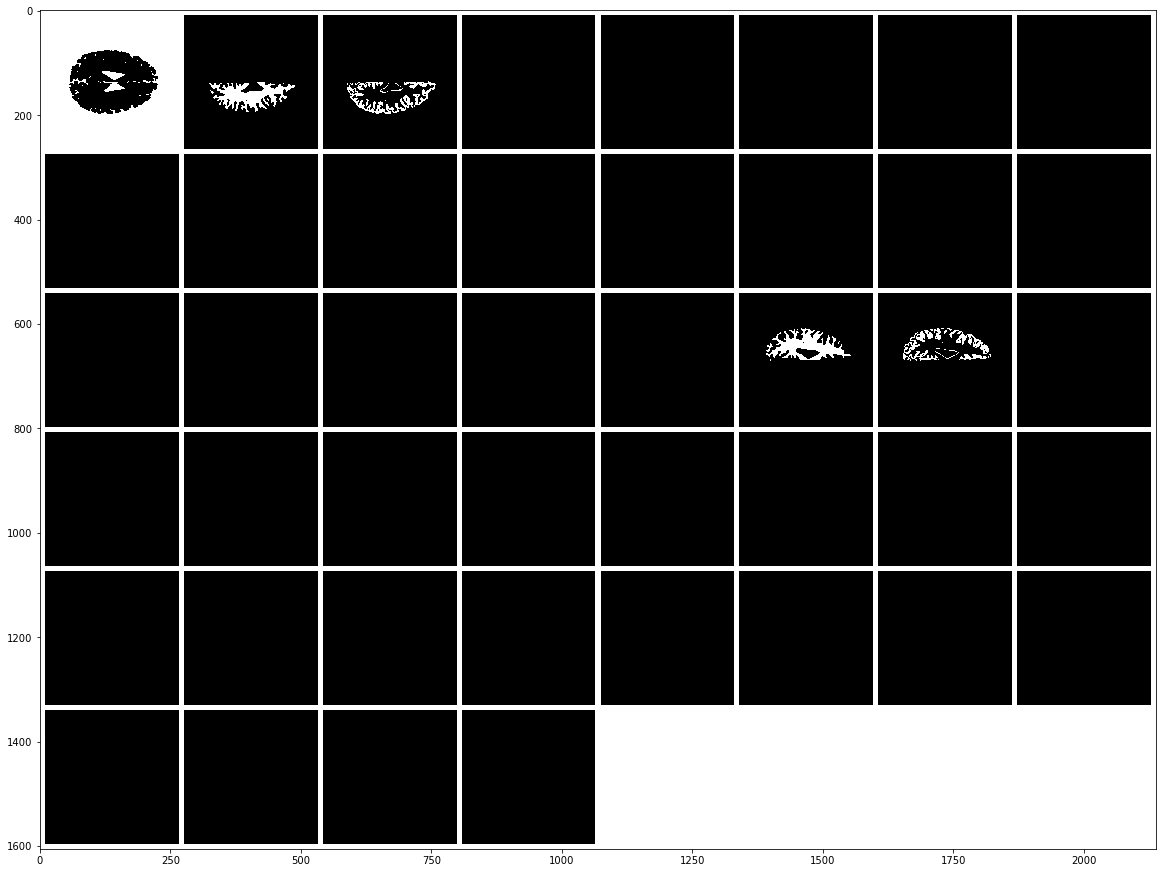

----------------------------------------------------------------------------------------------------
Ground Truth


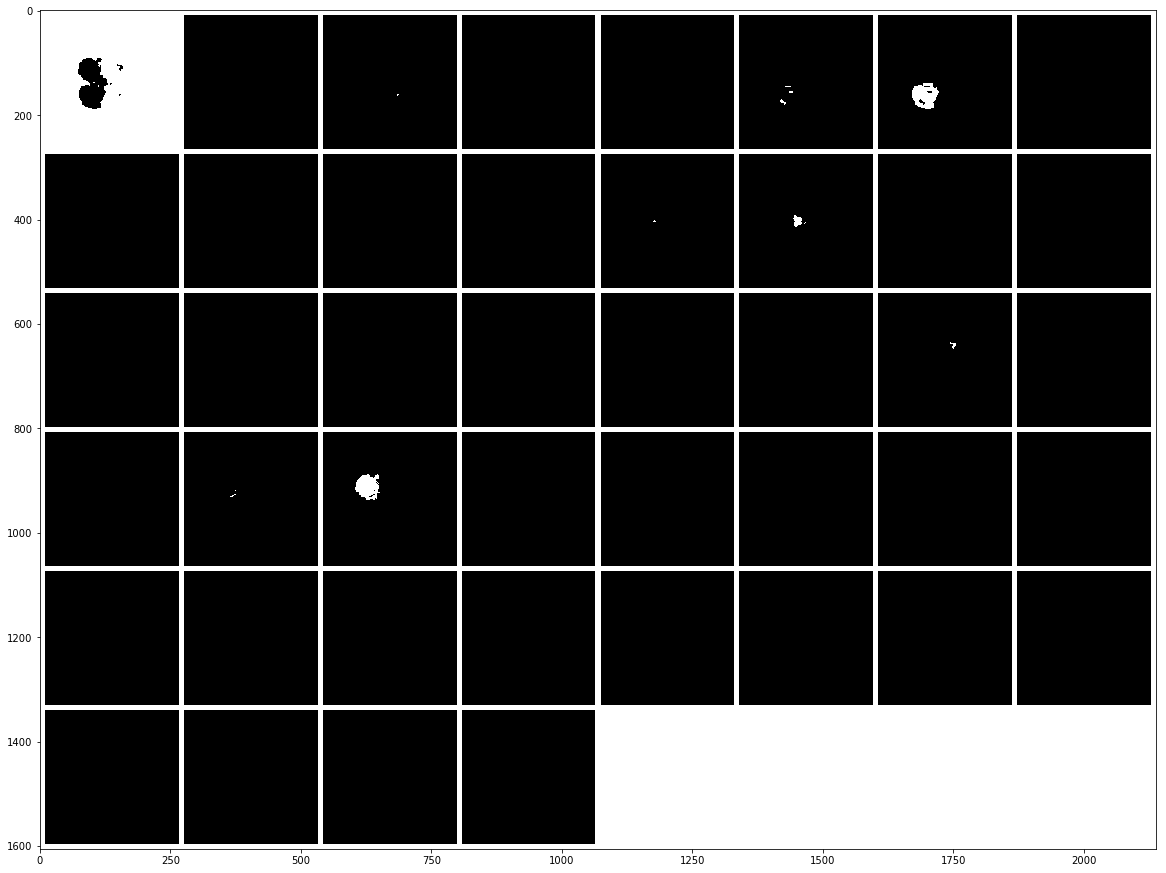

----------------------------------------------------------------------------------------------------
Prediction


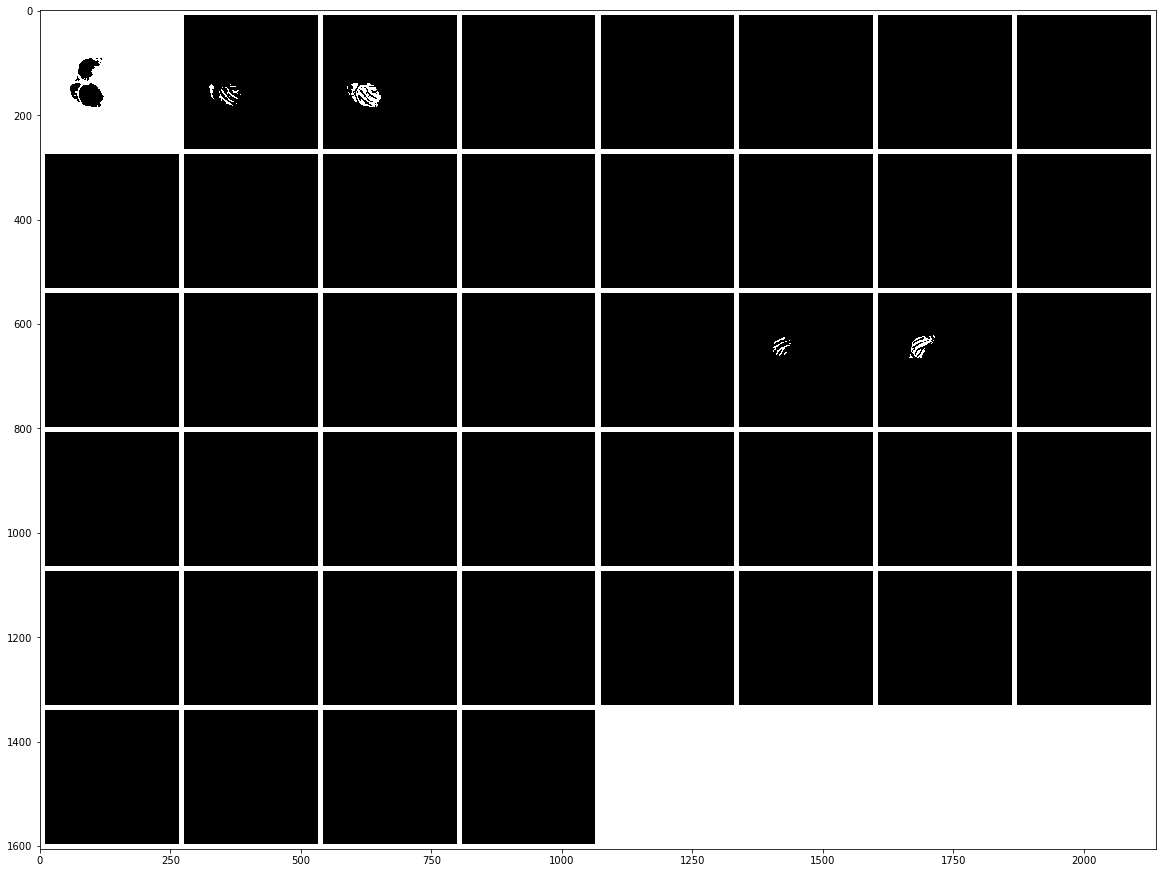

In [35]:
data = next(iter(dataloader["validate"]))
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)
for i in range(11):
    print('-'*100)
    print('Ground Truth')
    abc = data['y'][i,:,:,:]
    bcd = abc.resize(44,1,256,256)
    show(make_grid(bcd,padding=10,pad_value=1)) 
    print('-'*100)
    print('Prediction')
    show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))
    
    

In [42]:
names = []
for i in range(20):
    name = "epoch"+str(i)
    names.append(name)

In [43]:
train_dice_scores = pd.DataFrame(columns=names)
val_dice_scores = pd.DataFrame(columns=names)

In [44]:
for i in range(44):
    class_i_train = dice_hist[i]['train']
    class_i_val = dice_hist[i]['validate']
    #print(len(class_i_train))
    #print(len(class_i_val))
    train_dice_scores.loc[i] = class_i_train
    val_dice_scores.loc[i] = class_i_val

In [45]:
train_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10,epoch11,epoch12,epoch13,epoch14,epoch15,epoch16,epoch17,epoch18,epoch19
0,0.9965498,0.9971796,0.9970251,0.9971499,0.9970758,0.9972262,0.9968278,0.9851749,0.99708384,0.9970116,0.9975143,0.9975638,0.99737126,0.99766797,0.9973164,0.99750954,0.99759454,0.99757576,0.99736315,0.9976829
1,0.7166939,0.73798156,0.72679275,0.73413295,0.74086094,0.7281325,0.7403946,0.7305822,0.744449,0.73763573,0.7394013,0.75367594,0.74994326,0.7465426,0.7463005,0.7460979,0.7481523,0.7478051,0.75596684,0.7498402
2,0.69042975,0.7004013,0.69181496,0.7071021,0.699407,0.71042335,0.7004524,0.70423263,0.7177619,0.7140899,0.7200769,0.73074806,0.72635853,0.73204124,0.7208956,0.7186751,0.72593373,0.7228964,0.72907406,0.7357933
3,0.7916808,0.7859524,0.8046,0.79958004,0.78944594,0.7941424,0.7943429,0.78745115,0.790238,0.7855571,0.7932857,0.79231864,0.78710467,0.79464537,0.79503804,0.79233676,0.7968753,0.79425067,0.7899762,0.7862524
4,0.9093047,0.91272384,0.91171896,0.90793717,0.9133887,0.9004809,0.9175142,0.8980952,0.9059857,0.9056572,0.9062428,0.91366136,0.9118428,0.9159372,0.905938,0.9083142,0.91037107,0.9117424,0.9048523,0.9084858
5,0.67762375,0.6974906,0.6831334,0.6971169,0.6844048,0.67523634,0.6912048,0.67032725,0.69063807,0.6825049,0.6872809,0.6925217,0.6947763,0.69615763,0.68172854,0.6821277,0.68644625,0.68351984,0.68258566,0.69028103
6,0.55640495,0.5800335,0.5655999,0.5745399,0.5556421,0.5542936,0.5597906,0.5533549,0.5776477,0.56544757,0.5757001,0.56779754,0.5716667,0.5719039,0.5563571,0.56527835,0.5700411,0.5652477,0.5662905,0.5694096
7,0.8348523,0.83807147,0.8424571,0.8398228,0.8326792,0.833271,0.8288524,0.82386106,0.83443815,0.8304523,0.83752376,0.83457565,0.82944757,0.83637565,0.83550465,0.8382176,0.8377182,0.8342277,0.8352619,0.82424766
8,0.76929516,0.7587905,0.7794761,0.7772939,0.76225454,0.76161385,0.76402855,0.7561793,0.7655666,0.76266664,0.7695143,0.7664134,0.76177144,0.76411766,0.7701238,0.76532245,0.76845616,0.77015543,0.7658,0.75917137
9,0.811238,0.8042238,0.8034046,0.8154934,0.7963082,0.78901905,0.7985524,0.78837967,0.8036809,0.80380946,0.8119619,0.805323,0.80765224,0.806851,0.7995618,0.8067371,0.80583763,0.8062646,0.80153805,0.79315233


In [46]:
val_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10,epoch11,epoch12,epoch13,epoch14,epoch15,epoch16,epoch17,epoch18,epoch19
0,0.99802154,0.99706054,0.9970872,0.99777275,0.9977549,0.9976496,0.9973675,0.9973347,0.99758035,0.9972457,0.9977731,0.9974795,0.996771,0.997716,0.99721056,0.99740094,0.9972064,0.9974342,0.99715614,0.9977162
1,0.7410774,0.7009181,0.7479126,0.7164603,0.7409071,0.7414202,0.723949,0.7212836,0.74559534,0.74893904,0.7626427,0.75504416,0.713876,0.7320048,0.77963346,0.75375813,0.7289967,0.7714716,0.74891824,0.76576006
2,0.6990169,0.6637601,0.70847464,0.6873922,0.7096681,0.709609,0.66504264,0.694538,0.7136714,0.71732086,0.72907037,0.72104925,0.66359496,0.7198193,0.7367115,0.7191469,0.7146947,0.7465344,0.7209256,0.7329488
3,0.7723714,0.78556204,0.77207536,0.7852001,0.7969525,0.79494816,0.7775906,0.79163814,0.7973906,0.79212385,0.7795524,0.79170483,0.8046476,0.80841655,0.7748078,0.78087634,0.785381,0.7761975,0.7799144,0.7896745
4,0.88166666,0.8847715,0.8700849,0.8779715,0.8854191,0.8790659,0.8814,0.8794286,0.8804953,0.88782865,0.8928668,0.8841429,0.8686381,0.8789325,0.88169533,0.87668586,0.88071346,0.88605636,0.8677334,0.88634115
5,0.73926675,0.7321143,0.7246823,0.7186476,0.7316858,0.72703475,0.73277146,0.71471435,0.7248095,0.729943,0.7454478,0.7344096,0.71884763,0.72268236,0.7363499,0.7279524,0.7270061,0.73476803,0.71708584,0.73782426
6,0.58885723,0.57245713,0.58058536,0.5694763,0.5829239,0.5793272,0.5829048,0.5637334,0.5778953,0.5664571,0.59411436,0.57264763,0.57320005,0.5720711,0.5824433,0.5771239,0.57591,0.5947282,0.5555524,0.5824044
7,0.8249906,0.8270287,0.824904,0.83035254,0.8390002,0.84612054,0.82548577,0.83371437,0.8394478,0.83459055,0.8324763,0.8380286,0.8414287,0.8461222,0.81328493,0.8307239,0.82915246,0.816542,0.8196096,0.8362649
8,0.76024765,0.7690668,0.75770307,0.76200014,0.78089535,0.77752906,0.75512385,0.7695715,0.78232396,0.76633346,0.76216197,0.777381,0.78281915,0.78714037,0.75679743,0.76398104,0.7670286,0.75753075,0.7584096,0.77547455
9,0.8157715,0.8198001,0.81325555,0.8184192,0.8273716,0.8321014,0.8120382,0.8208191,0.8266477,0.818762,0.82682866,0.8266667,0.8326382,0.8347421,0.80543643,0.8228001,0.82171434,0.82876027,0.814743,0.8258745


----------------------------------------------------------------------------------------------------
Ground Truth


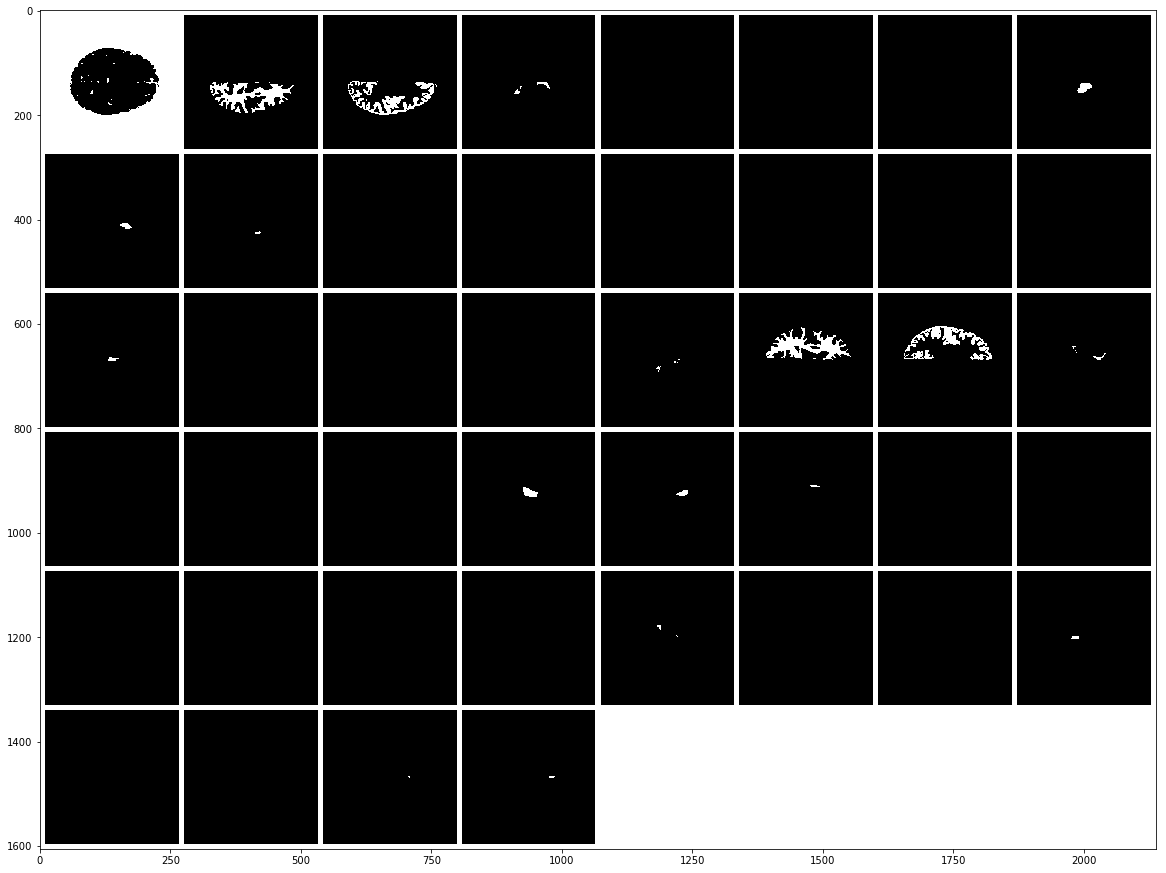

----------------------------------------------------------------------------------------------------
Prediction


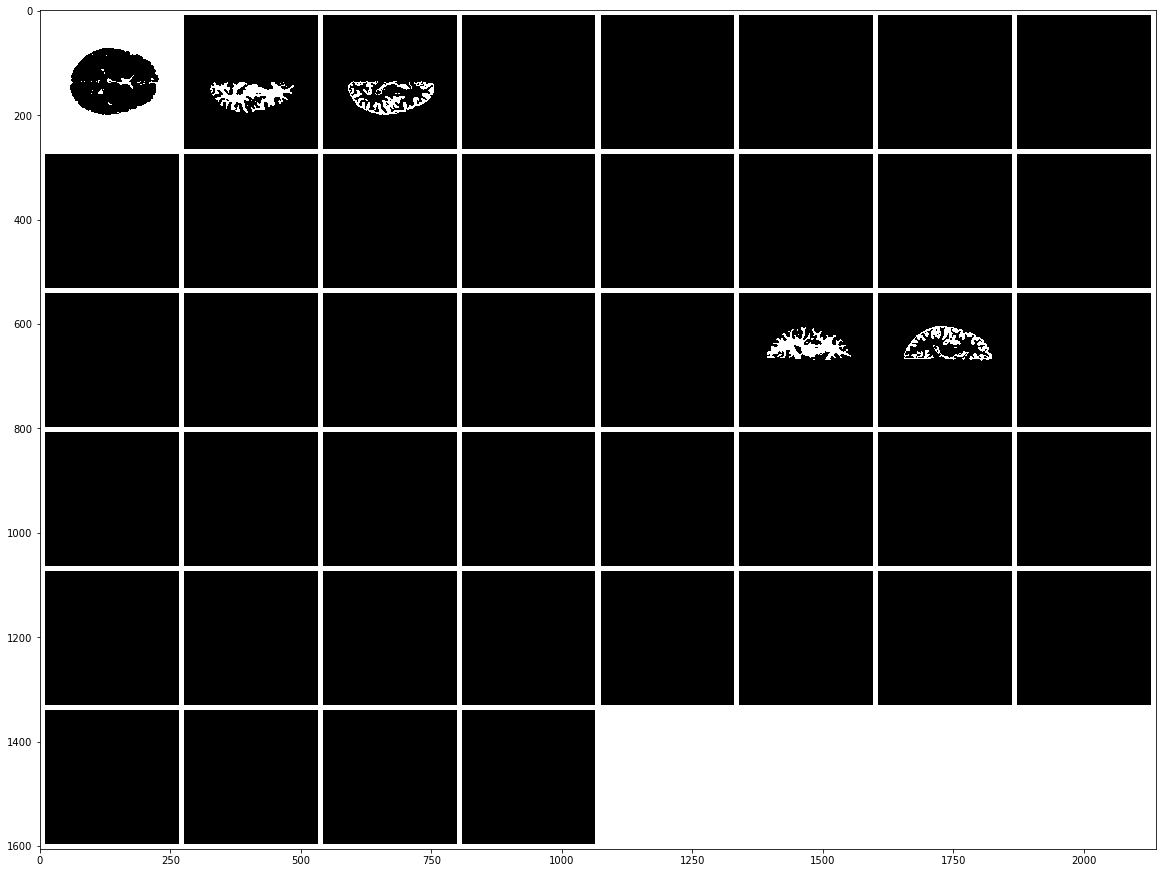

----------------------------------------------------------------------------------------------------
Ground Truth


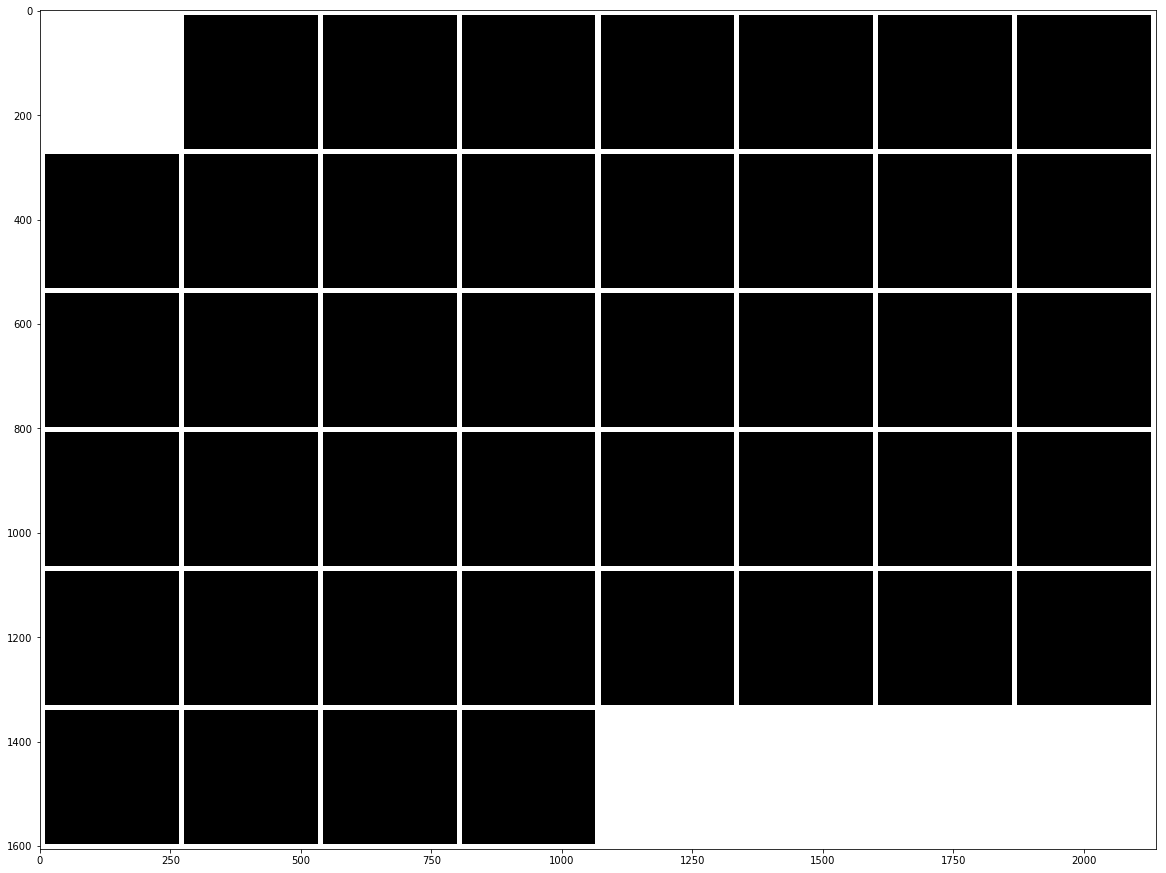

----------------------------------------------------------------------------------------------------
Prediction


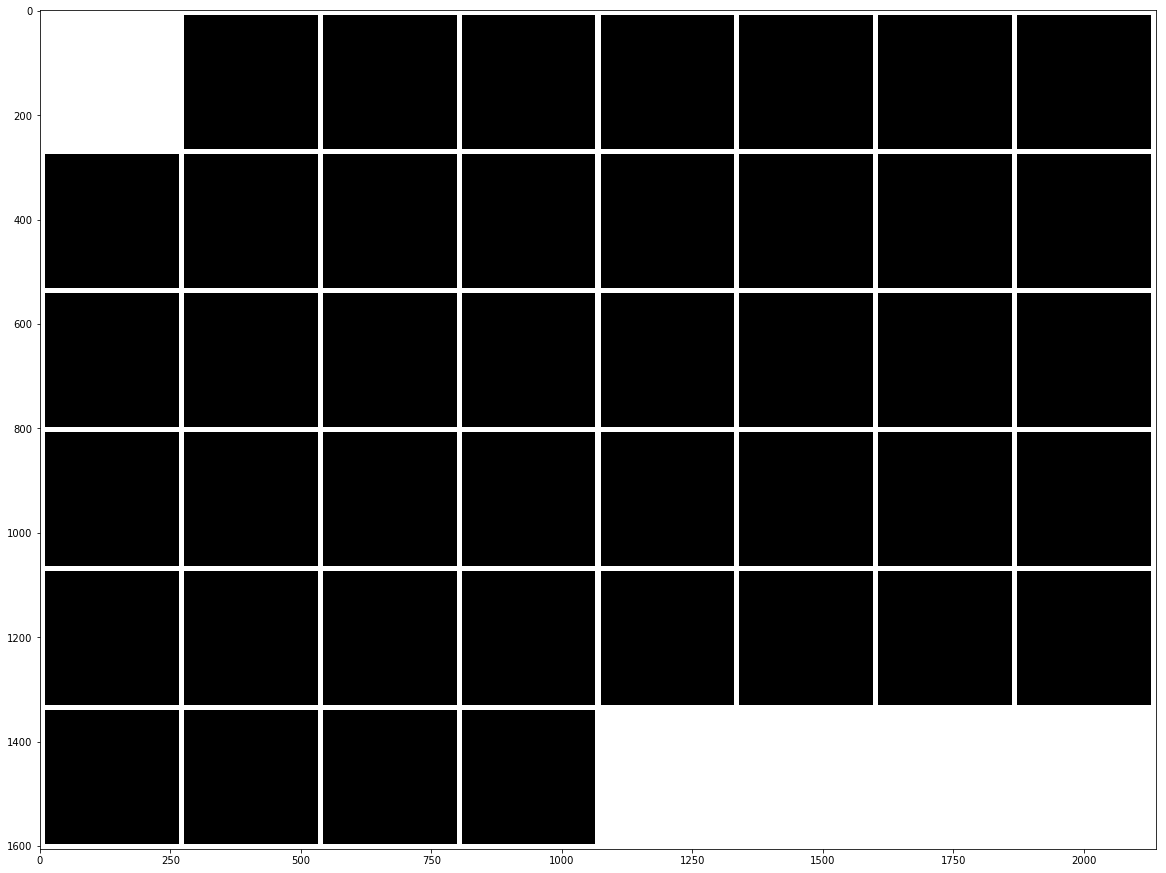

----------------------------------------------------------------------------------------------------
Ground Truth


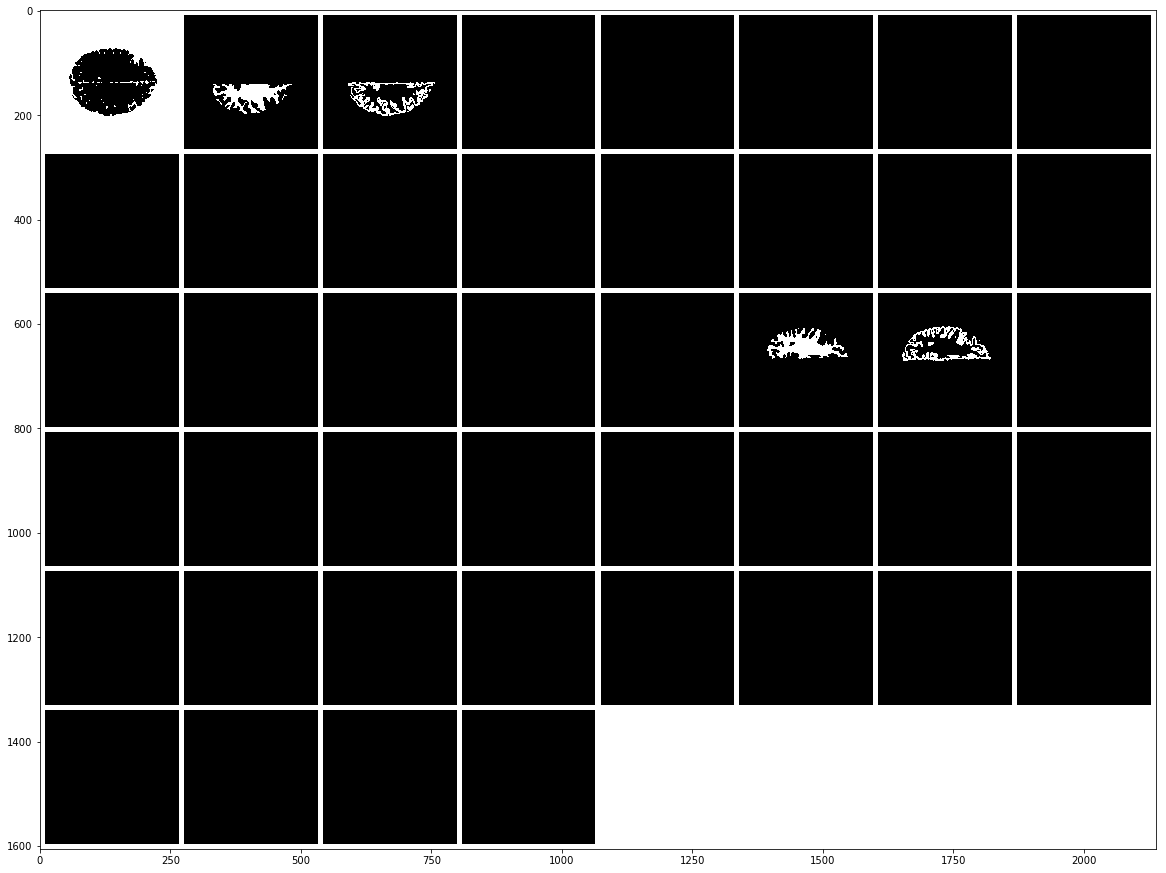

----------------------------------------------------------------------------------------------------
Prediction


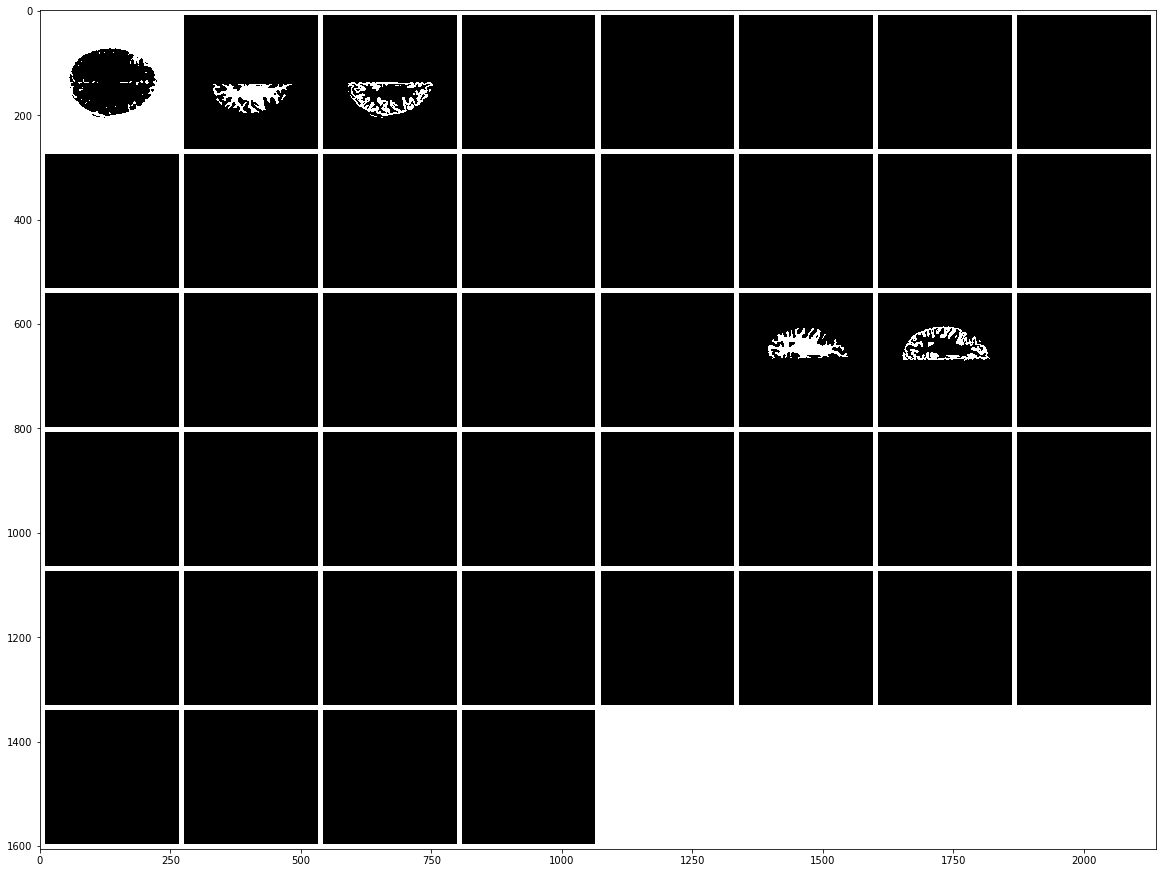

----------------------------------------------------------------------------------------------------
Ground Truth


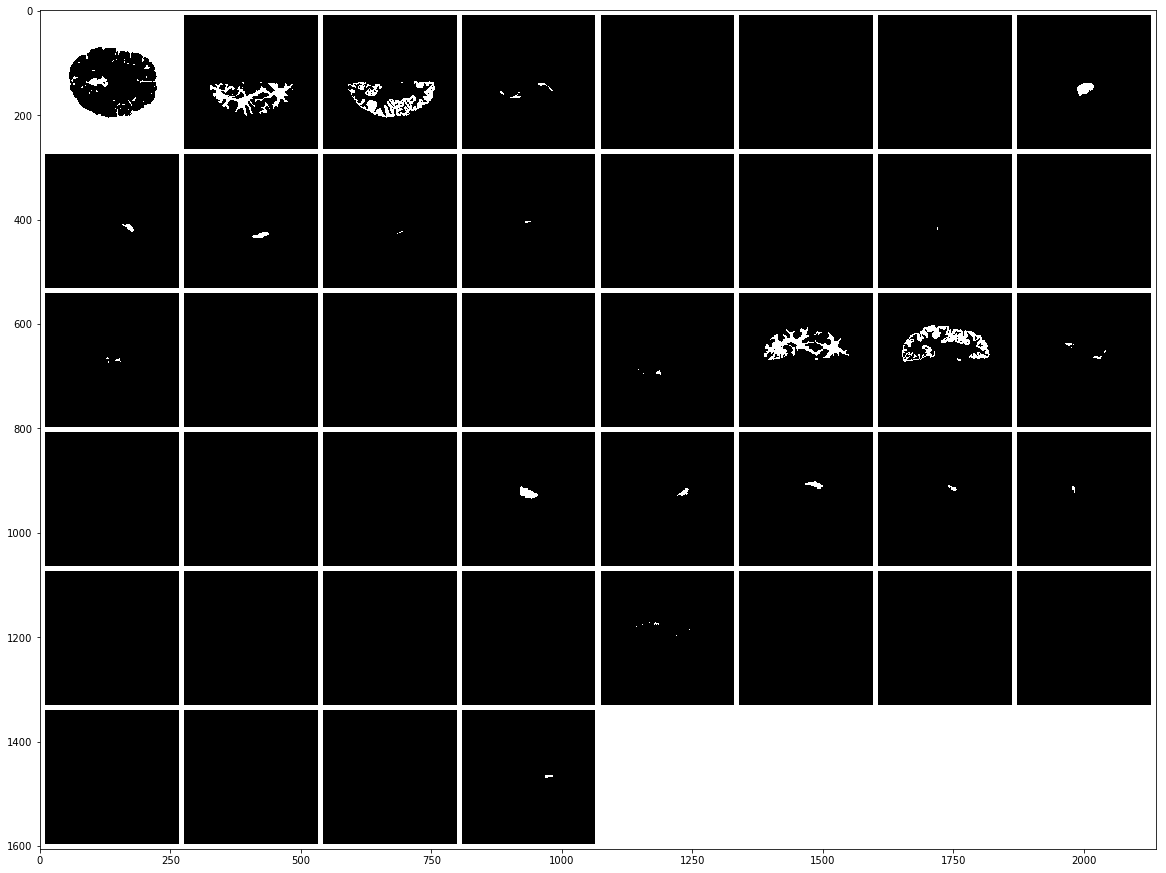

----------------------------------------------------------------------------------------------------
Prediction


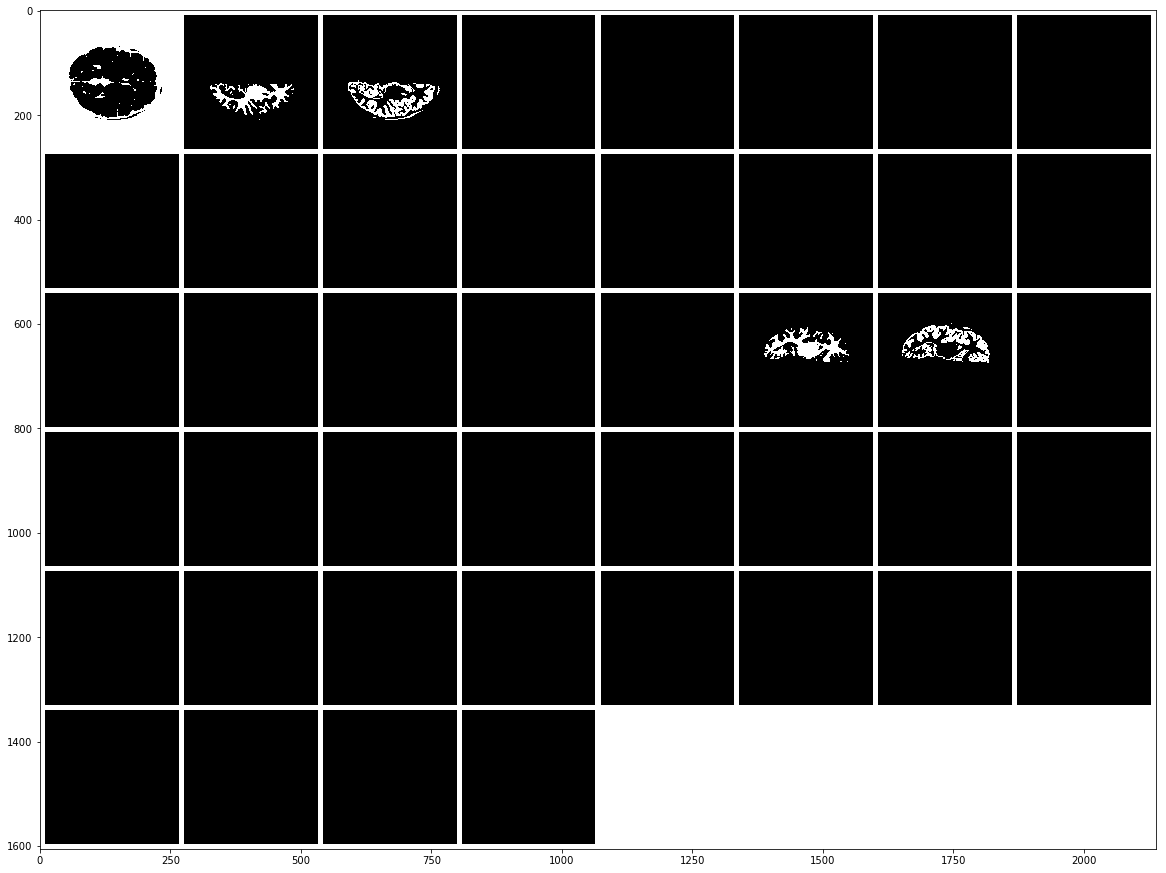

----------------------------------------------------------------------------------------------------
Ground Truth


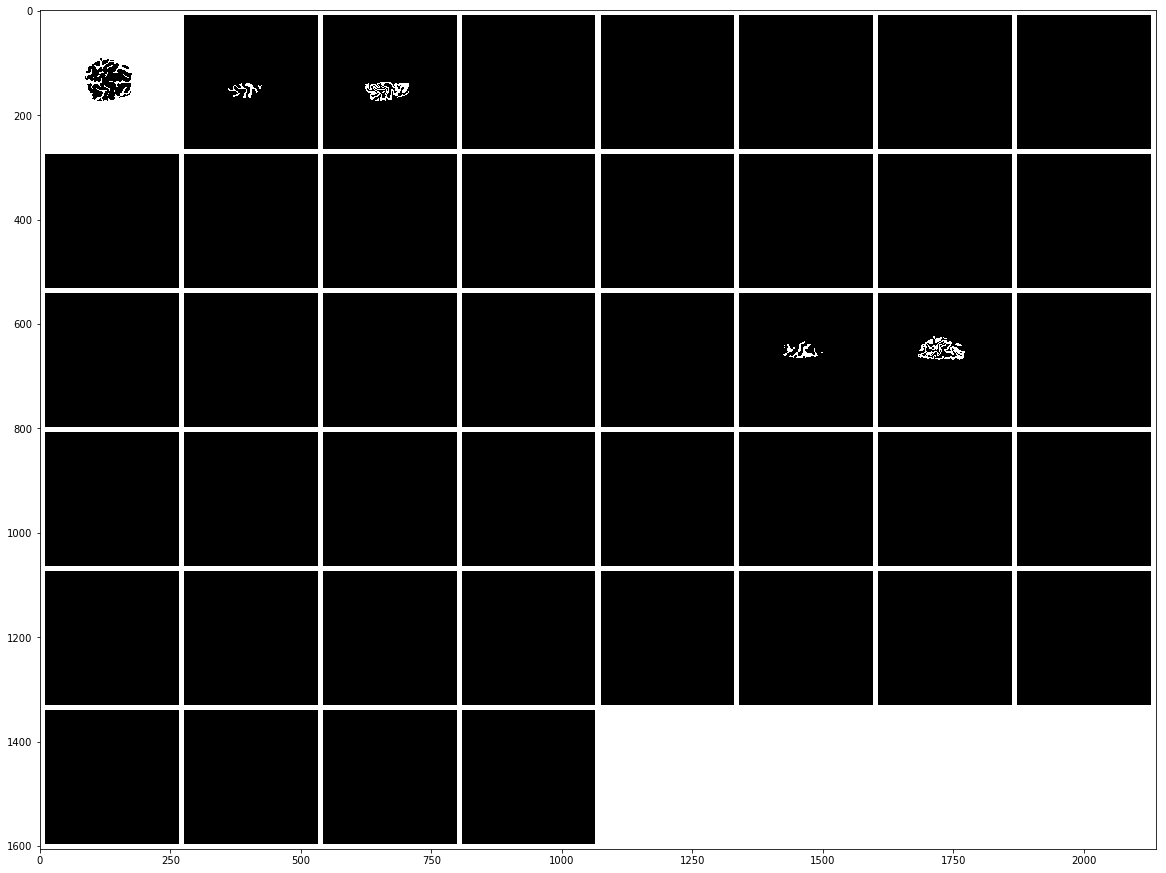

----------------------------------------------------------------------------------------------------
Prediction


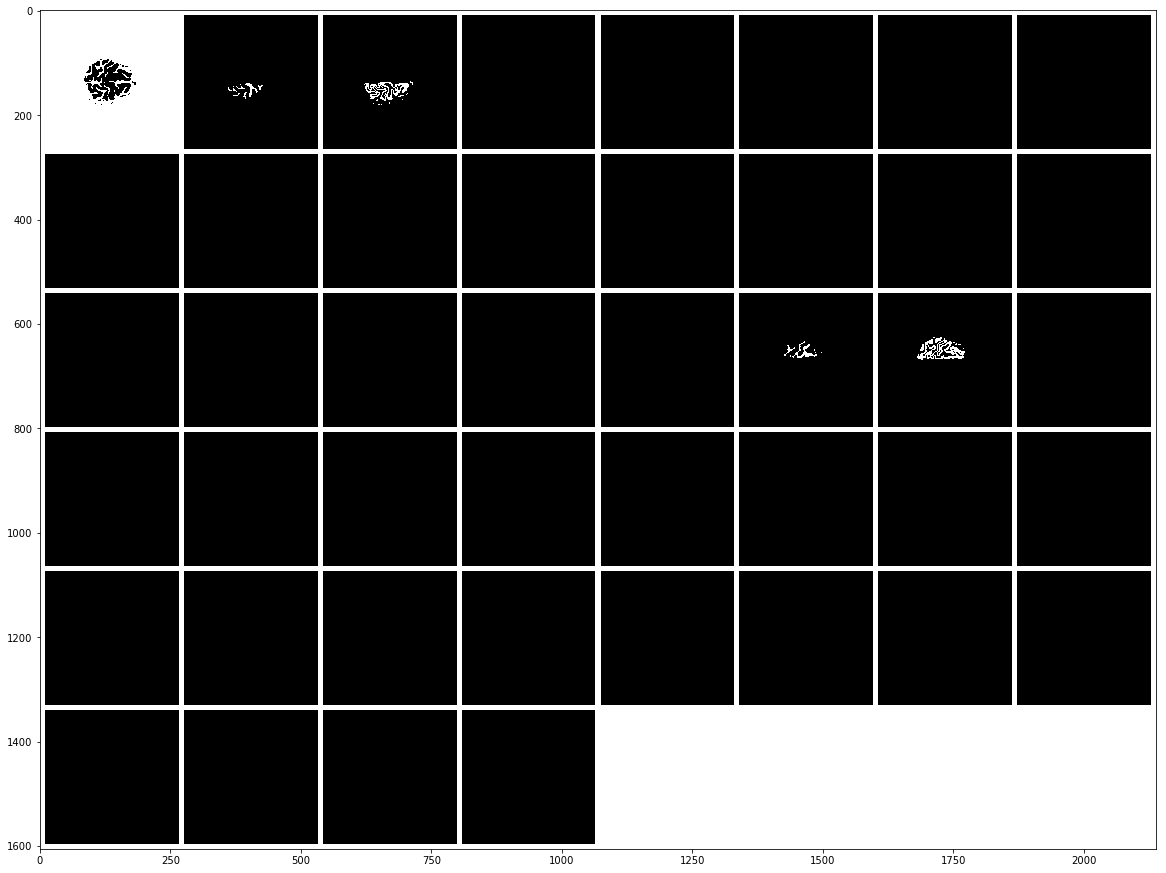

----------------------------------------------------------------------------------------------------
Ground Truth


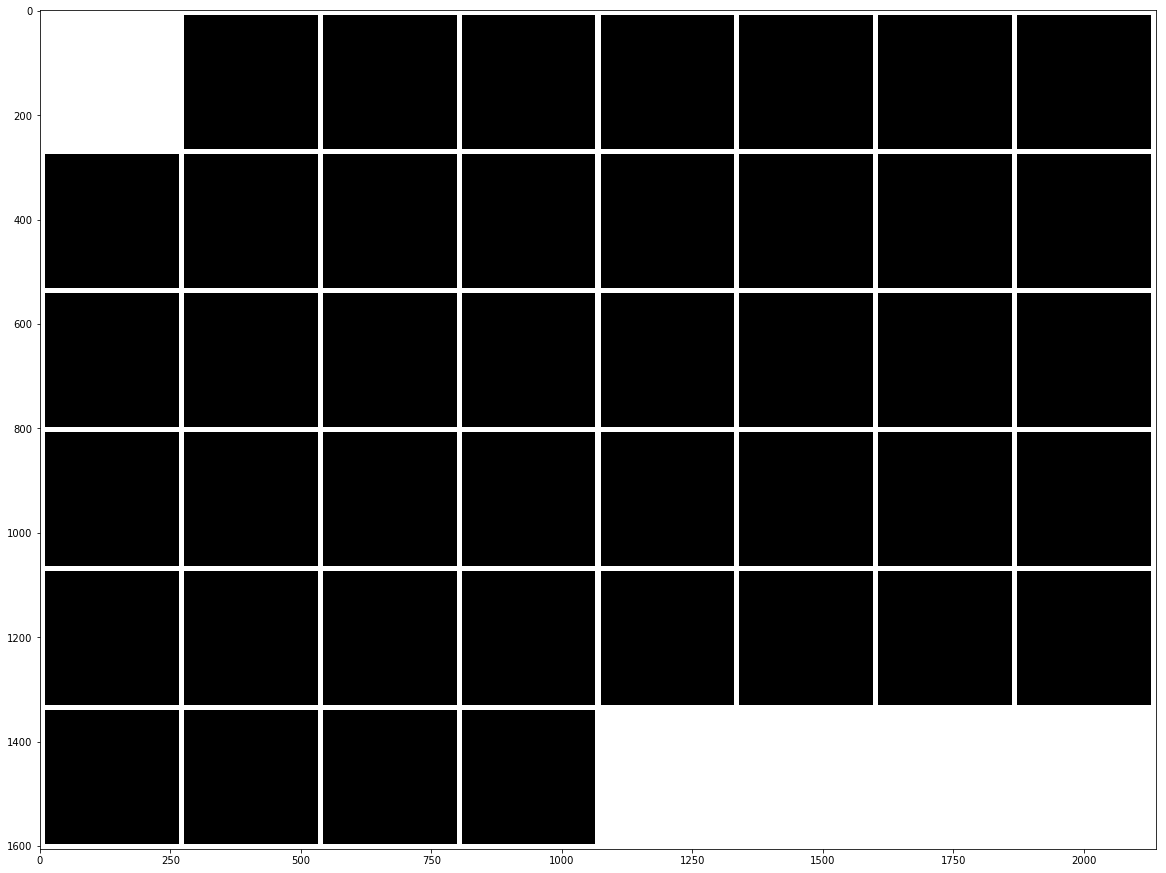

----------------------------------------------------------------------------------------------------
Prediction


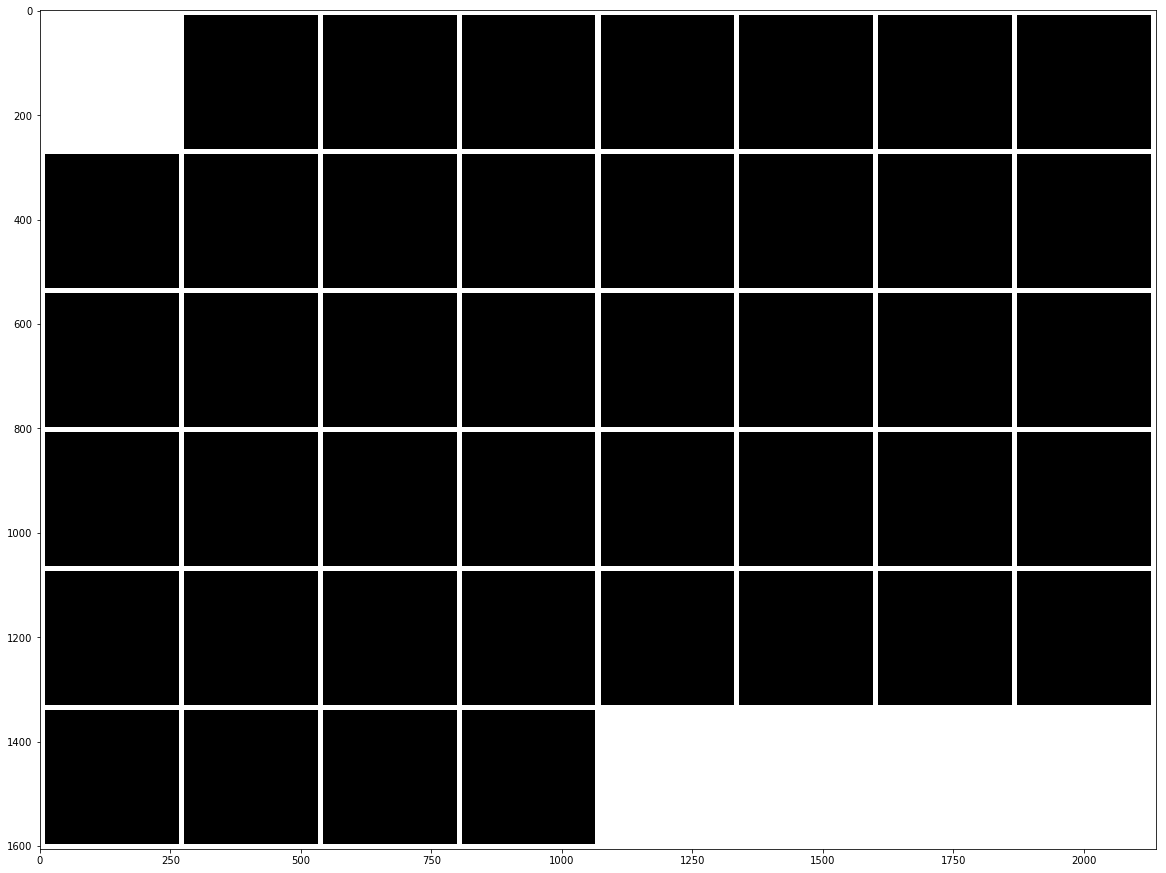

----------------------------------------------------------------------------------------------------
Ground Truth


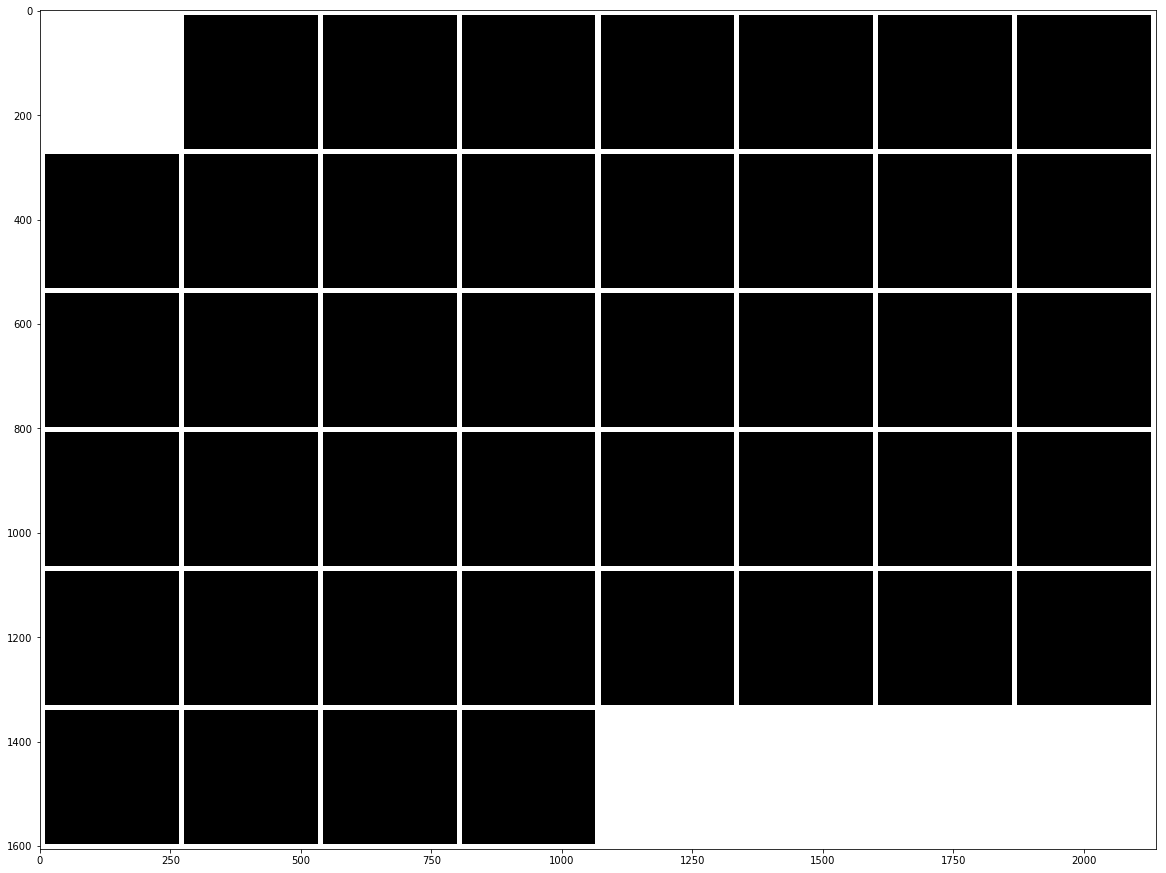

----------------------------------------------------------------------------------------------------
Prediction


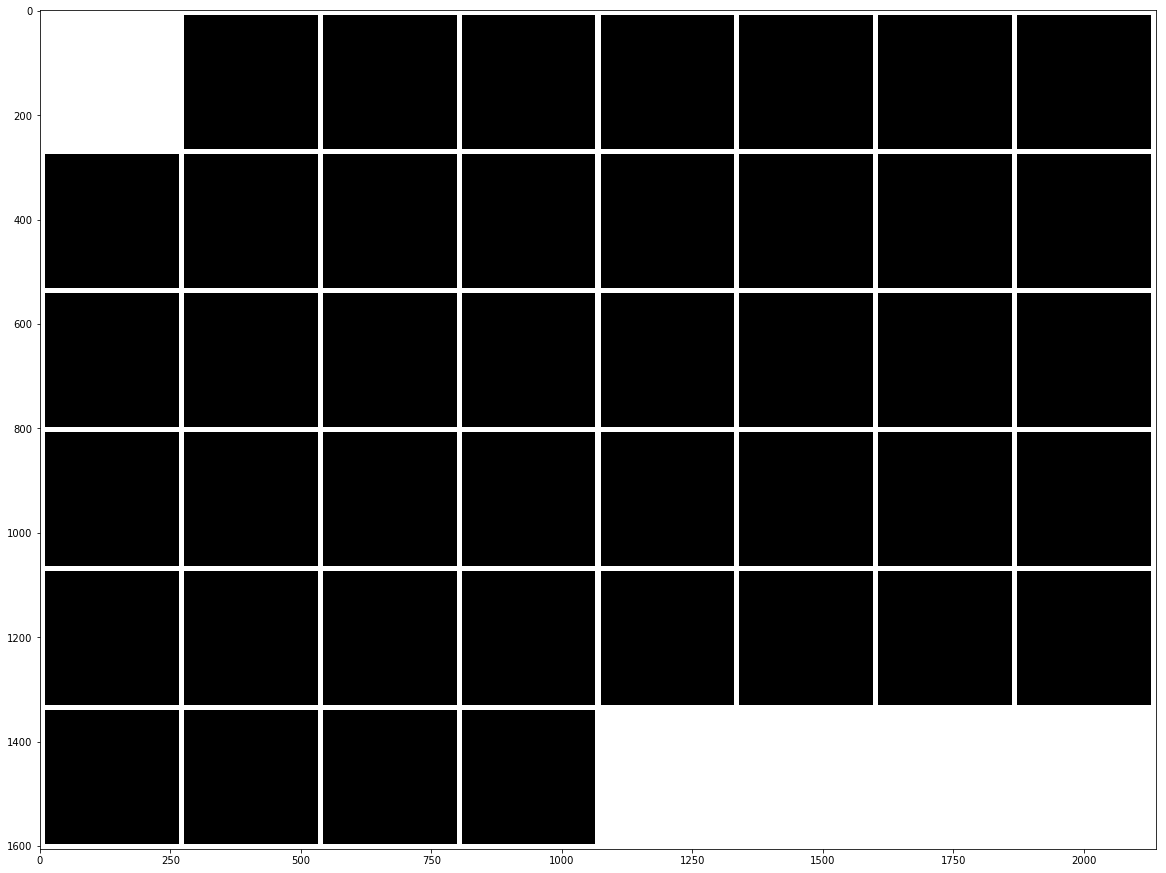

----------------------------------------------------------------------------------------------------
Ground Truth


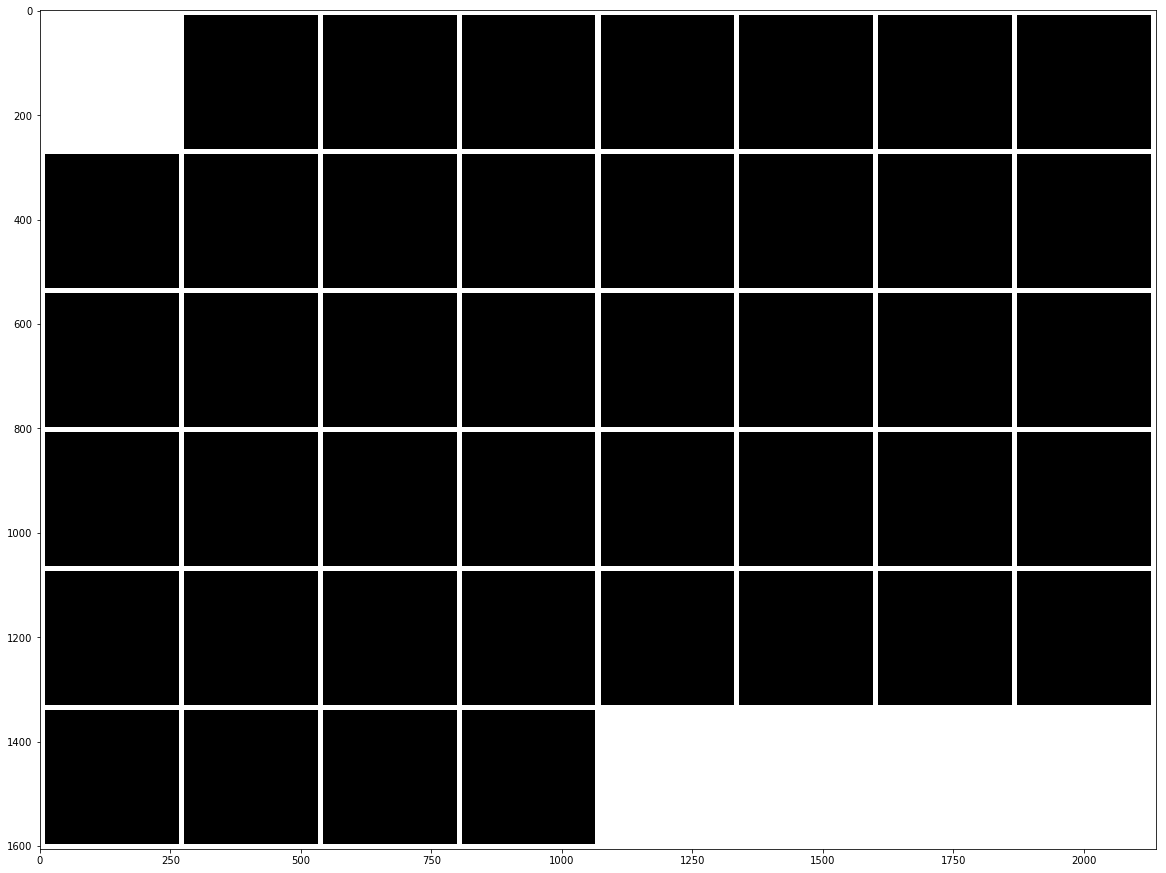

----------------------------------------------------------------------------------------------------
Prediction


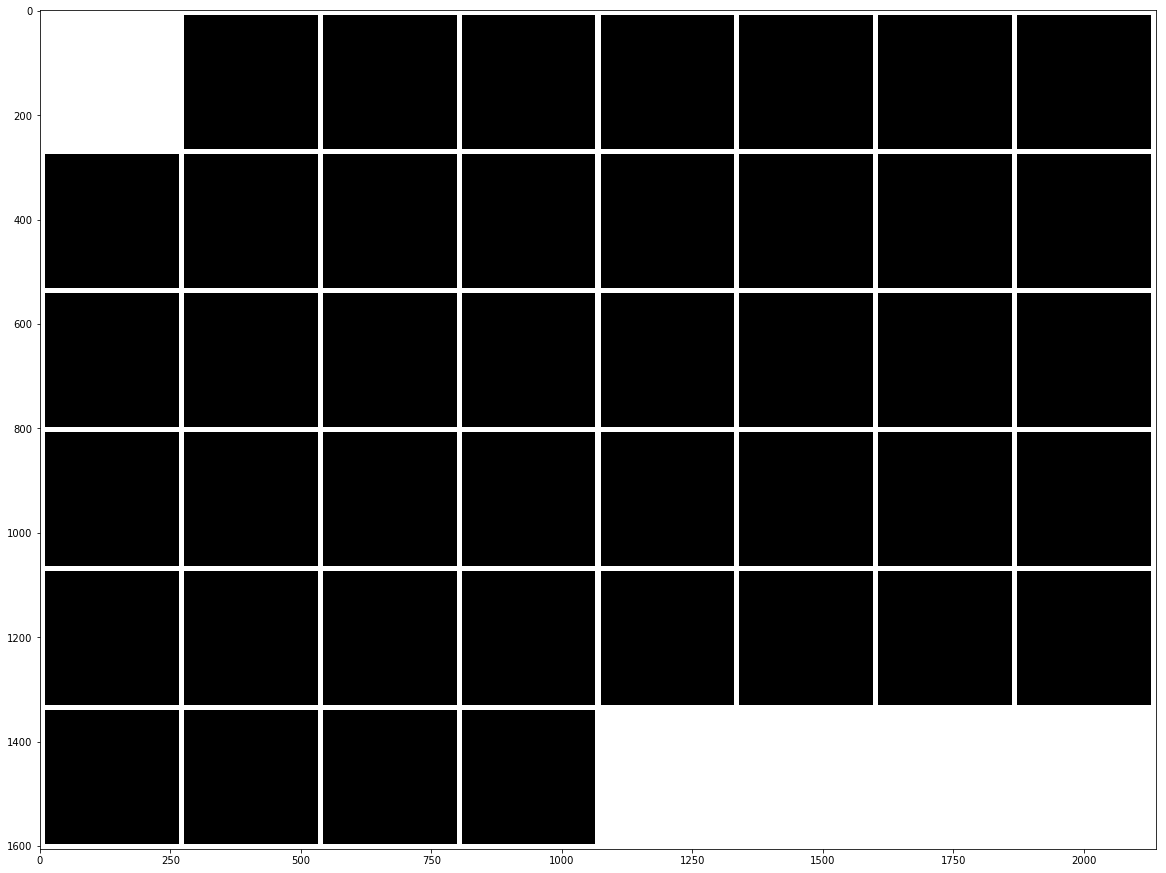

----------------------------------------------------------------------------------------------------
Ground Truth


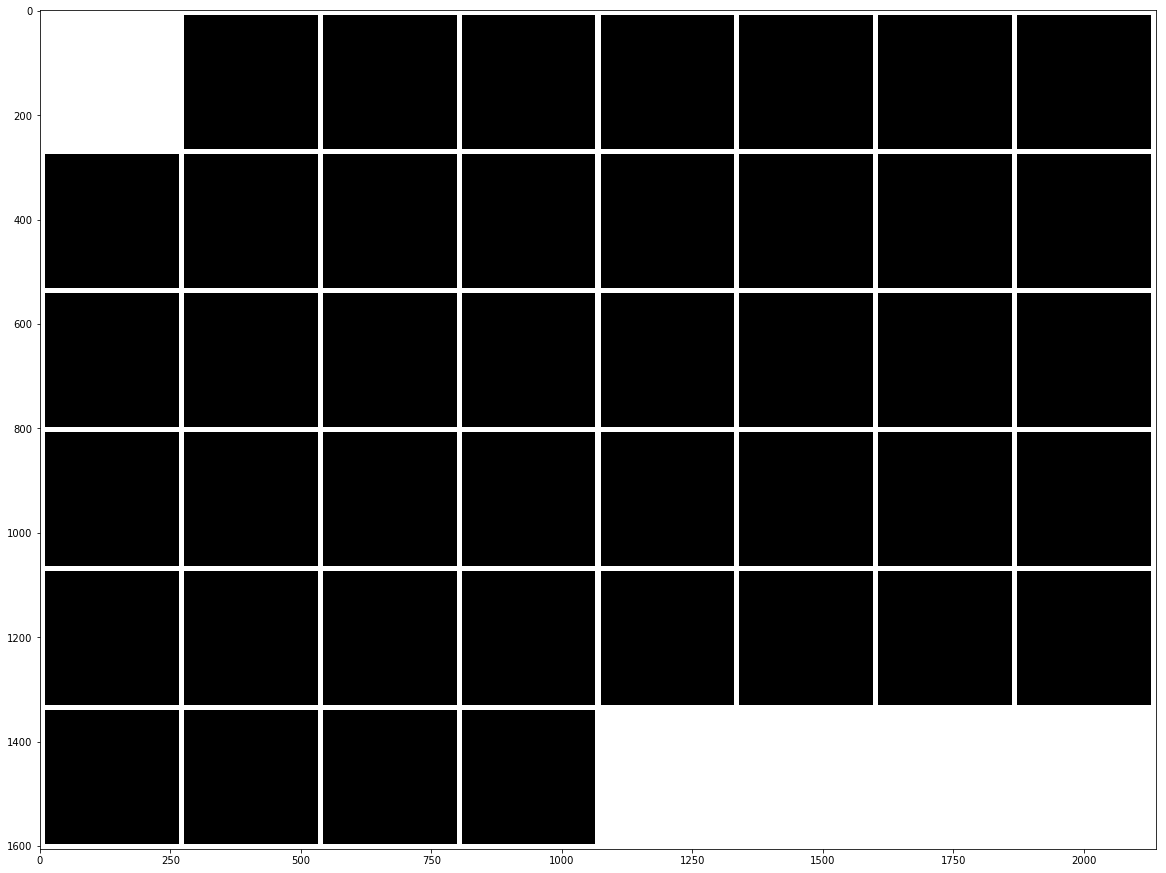

----------------------------------------------------------------------------------------------------
Prediction


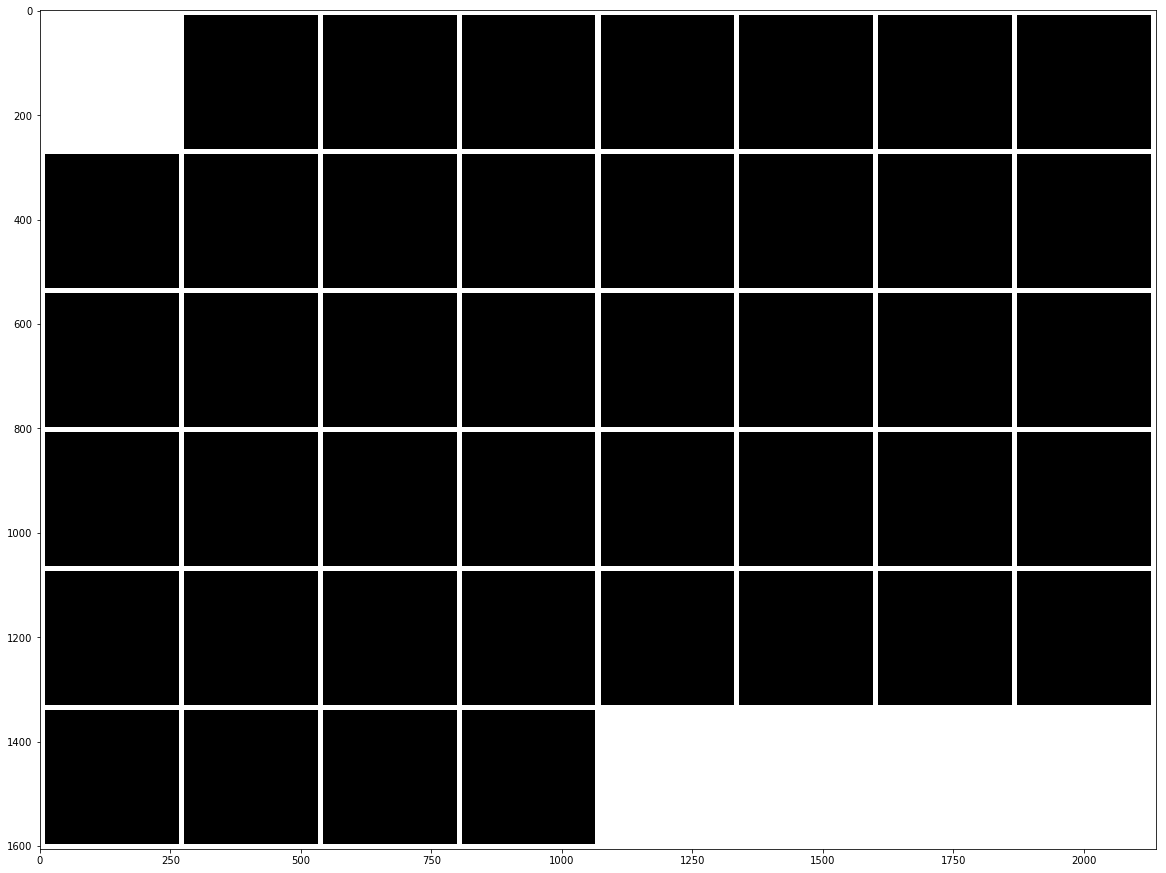

----------------------------------------------------------------------------------------------------
Ground Truth


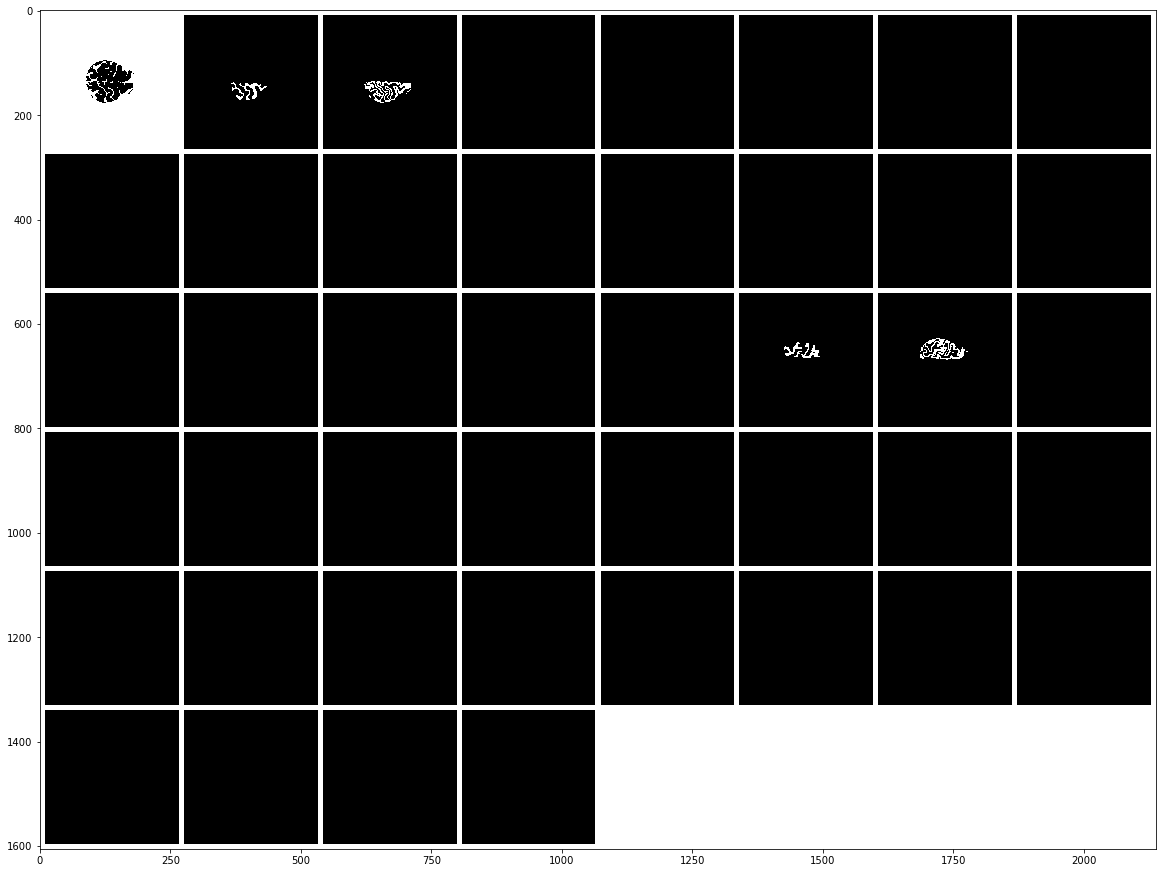

----------------------------------------------------------------------------------------------------
Prediction


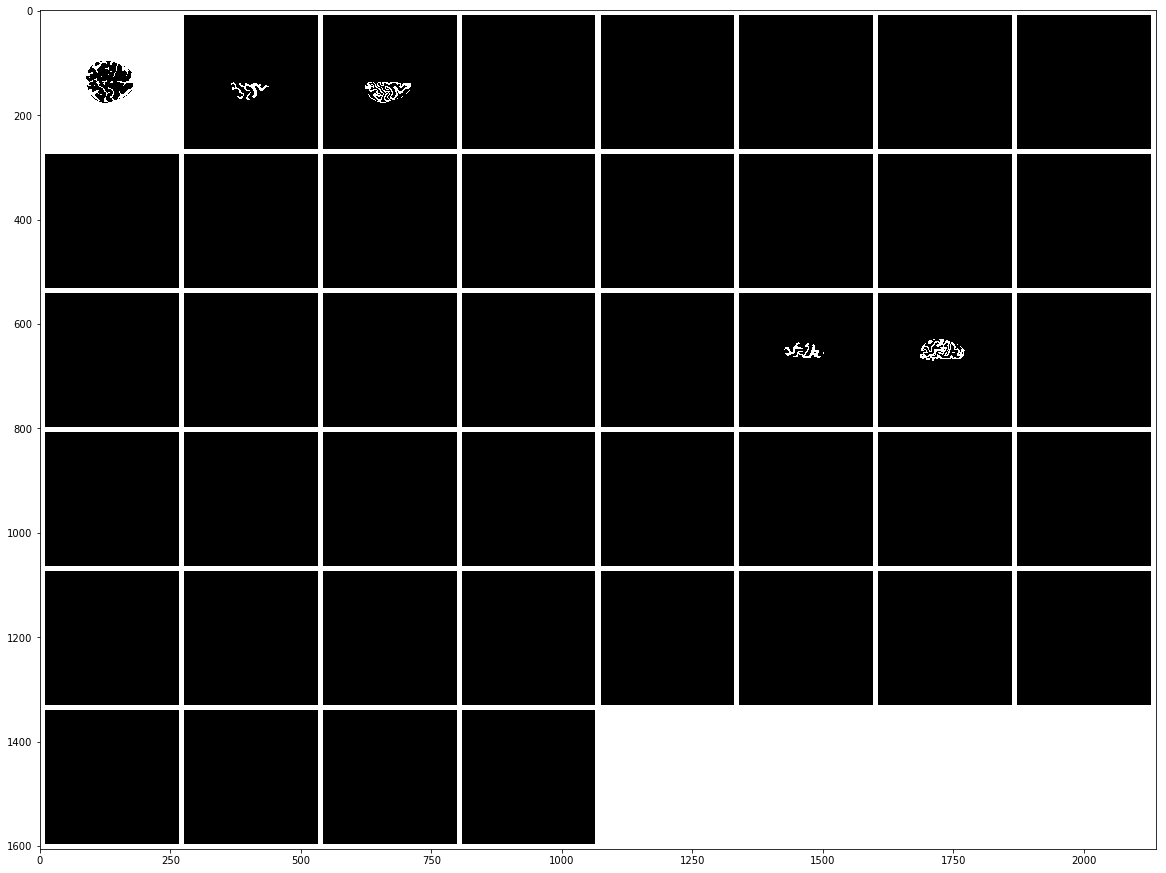

----------------------------------------------------------------------------------------------------
Ground Truth


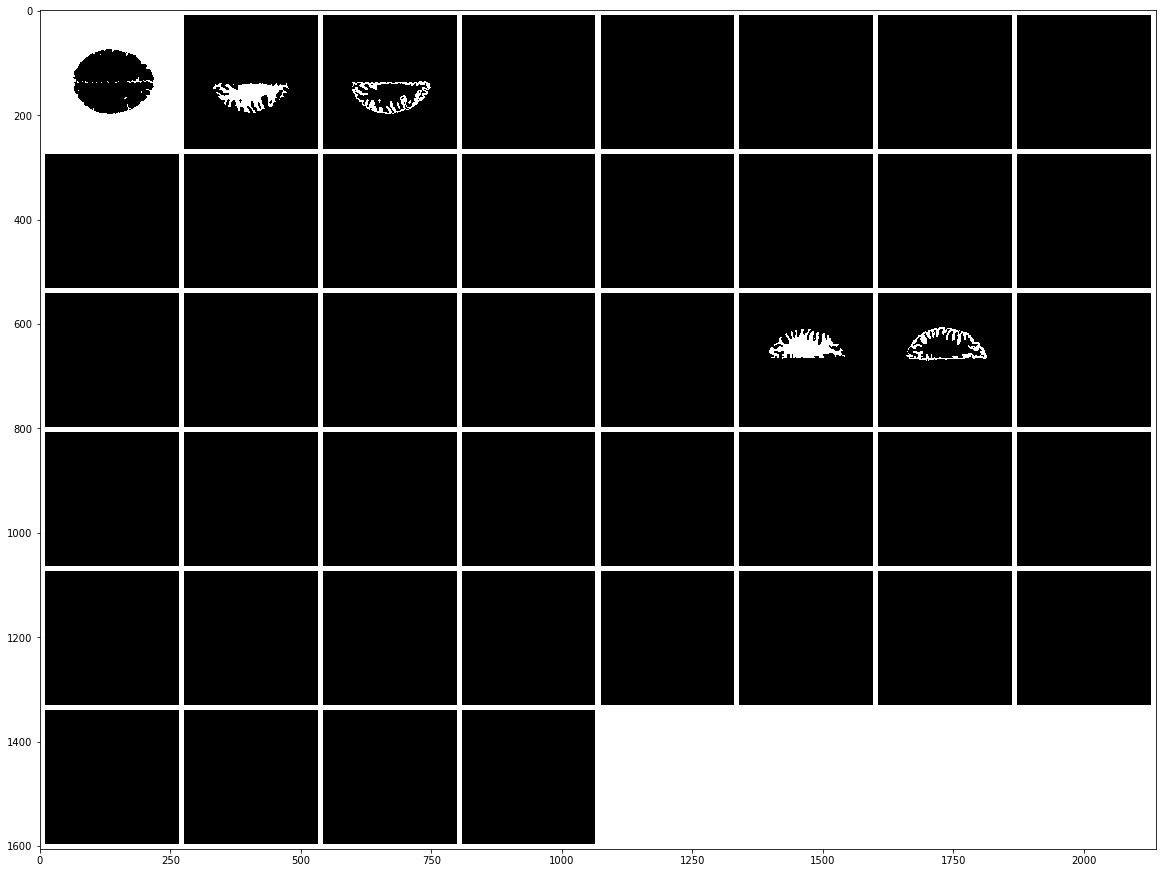

----------------------------------------------------------------------------------------------------
Prediction


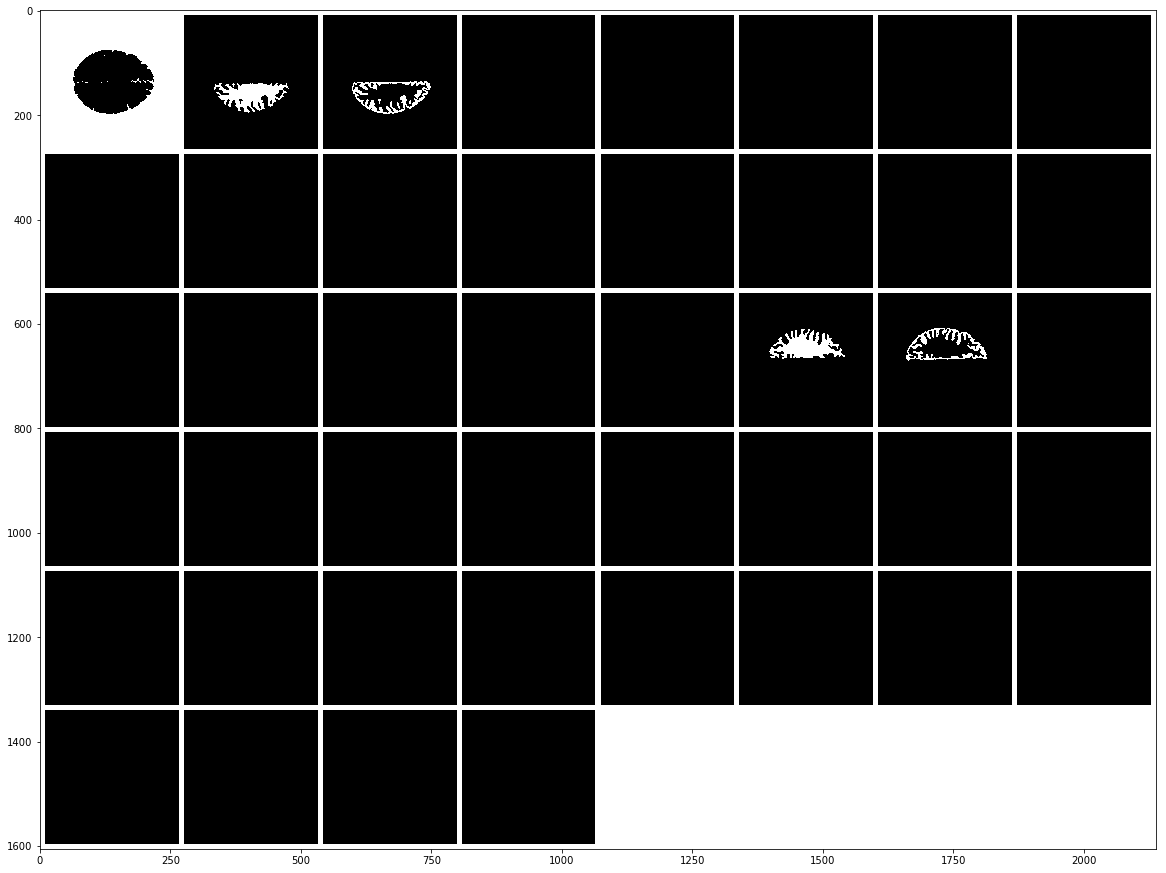

In [47]:
data = next(iter(dataloader["validate"]))
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)
for i in range(11):
    print('-'*100)
    print('Ground Truth')
    abc = data['y'][i,:,:,:]
    bcd = abc.resize(44,1,256,256)
    show(make_grid(bcd,padding=10,pad_value=1)) 
    print('-'*100)
    print('Prediction')
    show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))
    
    